# Training of Herkules Weight Forecast Project for National Parcels (NAT)

In [25]:
# 1. Import packages for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import openpyxl
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from  IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# 2. Import packages for time analysis
import time
import datetime as dt
from datetime import date
from datetime import timedelta
from datetime import datetime

# 3 Open Teradata Connection. Import packages for time analysis
from pnp_connectors.connection_config_holders import TeradataConfig
from pnp_connectors.quick_create import QuickCreate

# 3.1 create config
td_config = TeradataConfig(
 host="TDP-N0201.deutschepost.dpwn.com",
 secret_user_name=os.getenv("TERADATA_USER"),
 secret_password=os.getenv("TERADATA_PASSWORD")
)

# 3.2 create connection
td_connection = QuickCreate.create_teradata_connection(td_config=td_config)

# 4. Funktion zum Löschen nicht mehr benötigter Tabellen
def drop_table(tab_name):
    try:
        td_connection.execute_sql(f'''DROP TABLE {tab_name}''')
        print(f'''{tab_name} dropped.''')
    except: 
        print(f'''{tab_name} nicht vorhanden''')
         
def create_table(Tabelle, SQL, Index):
    # Falls notwendig löschen der neuen Tabelle, dann Tabelle ohne Daten erstellen und Daten einfügen:
    drop_table(Tabelle)
    td_connection.execute_sql(f'''CREATE MULTISET TABLE {Tabelle} AS ( {SQL}) WITH NO DATA PRIMARY INDEX({Index})''')
    print(Tabelle + ' initialised with PI ' + Index)
    td_connection.execute_sql(f'''INSERT INTO  {Tabelle} {SQL}''')
    test = td_connection.select(f'''select count(1) as anzahl_ds from {Tabelle}''')
    anzahl = str(test['anzahl_ds'].values[0])
    print(f'''{anzahl} DS injected into table {Tabelle}.''')
    print(' ')
    
# 5. test connection
result = td_connection.select("select * FROM DB_NEXTT_DWH.vw_event_zust where sendungs_code = '340434197332847059'")
result.head()

,SENDUNGS_CODE,MODALITAET,EREIGNIS_DATUM,EREIGNIS_ZEITSTEMPEL,LEIT_PLZ,LEIT_STR,LEIT_HNR,LEIT_PRODUKT_CODE,EPOS_KASSEN_NR,FILIAL_DIREKTIONS_NR,FILIAL_NIEDERLASSUNGS_NR,FILIAL_NR,FILIAL_STRASSEN_NAME,FILIAL_PLZ,FILIAL_ORTS_NAME,EPOS_VORGANGSART,EREIGNISTYP,ZIEL_PZ,ZIEL_ZUSTELLBASIS,ZIEL_ZUSTELLBEZIRK,ZIEL_ZUSTELL_ABSCHNITT,SENDUNGSART,EREIGNIS_JAHR,LISTENTYP,LISTEN_NR,LISTEN_POSITION,BENACHRICHTIGUNGS_IDC,NACHNAHME_BETRAG,NACHNAHME_ZAHLUNGSART,ENTGELT_BETRAG,ENTGELT_ZAHLUNGSART,ZOLLEINFUHR_BETRAG,ZAHLSCHEINENTGELT_KENNUNG,WAEHRUNG,STORNOKENNZEICHNUNG,SAMMELBEHAELTER_NR,FOLGETAG,EMPFAENGER,BETRIEBS_NR,ZUSTELLER_NAME,EMPFANGSKENNZEICHNUNG,EMPFAENGER_NAME,AUSWEIS_NR,AUSWEISBEHOERDEN_NAME,AUSWEISKENNZEICHNUNG,AUSWEISGUELTIGKEIT,ERSATZEMPFAENGER_NAME,HSC_ERROR_CODE,PROCESS_ID,DATA_SOURCE_ID,LINE_NO,LOAD_TIMESTAMP,DATA_SOURCE_TYPE_ID,APPL_01_FLAG,APPL_02_FLAG,APPL_03_FLAG,APPL_04_FLAG,APPL_05_FLAG,APPL_06_FLAG,APPL_07_FLAG,APPL_08_FLAG,LP_DATA_SOURCE,HANDSCANNER_VERSION,ZAHLUNGSART,RUECKFUEHRUNGSENTGELT_BETRAG,UNTERZEICHNER_NAME,MANUELLE_EINGABE,SENDUNGSART_2,PRODUKT_TYP,ZUORDNUNGS_ID,TAS_AUFTRAGS_NR,AUFTRAGSKENNZIFFER,UNBAR_BETRAG,BAR_BETRAG,VERSCHLUESSELUNG,CEP_VERS,CEP_MINLESE_VERS,STATIONSKENNUNG,PST_PLZ,PST_NR,UNTERSCHRIFTSART,SST_PST_NEXTT,SENDUNGS_CODE_TYP,ANZ_N_NACHW_PFL_SDG,LFD_NR_TAS_M_SCANN,MEZ_KUNDENNUMMER,PST_KUNDEN_NR,DROPPOINT_NR,DIENST_KZ,JOURNALSATZNR,AUSWEIS_SONDERFALL,NACHNAHME_BETRAG2,ENTGELT_BETRAG2,BELEGPOS_ENDE,LOAD_ID,N_AUFTRAGSNUMMER,POSITIONSNUMMER,ESR_KENNZIFFER,STATIONSKENNUNG_2,LEITINFO_ALT,SHIPMENT_NR,AUSLIEFER_FLAG,ANZAHL_PS,POSITION_NO,LC_GESCANNT,SCANNER_ID,PERSONAL_NR,GEB_DATUM,ALTERSGRENZE,STP_ID,SCAN_ORT,GRUENE_KARTE,FILIAL_OZ,IDP_KORR,VERTRAGS_IDC,SESSION_ID,ZUSTELL_FLAG,TEZU_DATUM,GID,ZAHLUNGSEMPFAENGER,KONTONUMMER,BLZ,VERWENDUNGSZWECK_1,VERWENDUNGSZWECK_2,FREITEXTWERT,FREITEXT,FREITEXT_KORREKT,STAATSANGEHOERIGKEIT,STAATSANGEHOERIGKEIT_KORREKT,AUSWEISARTID,MELDEANSCHRIFT,VERTRAGSABWICKLUNG,FELDVALIDIERUNGFEHLGESCHLAGEN,AST_ID,POSTCARD_NR,EEA_FLAG,EEA_STRASSE,EEA_HNR,BETRIEBS_NR_KN,UNTERZEICHNER_NAME_KN,EVENT_ID,ARCH_ZEITRAUM,ETL1_DATA_SOURCE_ID,ETL1_LOAD_ID,ETL1_LOAD_DTM,ETL1_LINE_NO,IBAN,BIC,SERVICE_KUERZEL,EVENT_PSLZ_ID,ERZEUGUNGSORT_LAENDERCODE,LAGERN_BIS_DT,UNTERSCHRIFT_BILD_ID,UNTERSCHRIFT_BILD_INHALT,UNTERSCHRIFT_BILD_EXISTS_FLAG,AUTHENTIFIZIERUNGS_TYP,UNTERSCHRIFT_BILD_MIME_TYPE,ERZEUGUNGSORT_AGNR,ARCH_FLAG,ESR_ZUSTELL_DATUM,PAKETKASTEN_ID,POSTMAN_POSTNUMBER,POSTMAN_LOGISTIC_PROVIDER,LOGISTIK_NETZ,PPO_VERS,EINLIEFERER_VORNAME,EINLIEFERER_NAME,EINLIEFERER_STRASSE,EINLIEFERER_HNR,EINLIEFERER_PLZ,EINLIEFERER_ORT,EINLIEFERER_LAENDERCODE,EMPFAENGER_VORNAME,EMPFAENGER_STRASSE,EMPFAENGER_HNR,EMPFAENGER_PLZ,EMPFAENGER_ORTSNAME,EMPFAENGER_LAENDERCODE,EVENT_ART_PAKETSHOP,NICHT_ZUSTELLUNGSGRUND,UEBERGABE_VON,UEBERGABE_ZU,EXTERNE_PAKETSHOP_ID,ISBT_PAKETSHOP_NR,PLZ_CODE_PAKETSHOP_NR,PAKETSHOP_LAENGENGRAD,PAKETSHOP_BREITENGRAD,PAKETSHOP_STRASSEN_NAME,PAKETSHOP_HAUSNUMMER,PAKETSHOP_HAUSNUMMER_ZUSATZ,PAKETSHOP_PLZ,PAKETSHOP_ORTS_NAME,PAKETSHOP_LAENDERCODE,PAKETSHOP_INTERNATIONAL_NR,PAKETSHOP_BETRIEBSMODUS,SERVICE_EMPFAENGER_NACHNAME,SERVICE_EMPFAENGER_VORNAME,PAKET_STATUS,FSHDUPLIKAT_FLAG,GUELTIG_FLAG,ODS_EVENT_ID,PRIMARY_CRITERIA,SECONDARY_CRITERIA,CORR_TO_BE_ARCHIVED_ORIGINATOR,CORR_SCRIPT_ID,CORR_INSTRUCTION_ID,CORR_PROTOCOL_VERSION,CORR_ERROR_CODE,CORR_CHECK_CODE,CORR_ORIG_EVENT_ID,CREATION_LOC_ADDRESS_COUNTRY,PROD_LOCATION_CODE_AGNR,FORMAT_ADJUST_SYNTHETIC_EVENT,FORMAT_ADJUST_CORRECTION_TS,FORMAT_ADJUST_REVISER,FORMAT_ADJUST_COMMENT,FORMAT_ADJUST_POST_PROC_ADJUST,FORMAT_ADJUST_ORIG_EVENT_ID,FORMAT_ADJUST_ORIG_EVT_PRED_ID,EVT_MSG_HDR_DS_DSTID,PSLZ_ID,SHIP_ID,VALID_ROUTING_CODE_TYPE_1,VALID_RC_1_COUNTRY_CODE,VALID_RC_1_POSTAL_CODE,VALID_RC_1_STREET_CODE,VALID_RC_1_HOUSE_NUMBER,VALID_RC_1_PRODUCT_CODE_BASIS,VALID_RC1_PRODUCT_CODE_FEATURE,VALID_ROUTING_CODE_TYPE_2,VALID_RC_2_COUNTRY_CODE,VALID_RC_2_POSTAL_CODE,VALID_RC_2_STREET_CODE,VALID_RC_2_HOUSE_NUMBER,VALID_RC_2_PRODUCT_CODE_BASIS,VALID_RC2_PRODUCT_

# Initialisierung Projekt:

In [7]:
x = 1

now = date.today()
jahr_akt = now.year
monat_akt = now.month 

#Determination of the “previous month”:
if monat_akt == 1:
    monat = 11
    jahr = jahr_akt - 1
elif monat_akt == 2:
    monat = 12
    jahr = jahr_akt - 1
else:
    monat = monat_akt - 2
    jahr = jahr_akt

#Loop over the last 10 months
while x <= 5:

    if monat == 12:
        monat2 = 1
        jahr2 = jahr + 1
    else:
        monat2 = monat + 1
        jahr2 = jahr

    datum1 = date(year = jahr, month = monat, day = 1)  # First day of analysis
    datum2 = date(year = jahr2, month = monat2, day = 1) #  First day NOT included in the analysis
    datum1_PAN = datum1 + timedelta(days=-10)
    datum2_PAN = datum2 + timedelta(days=+10)

    print(datum1, datum2, datum1_PAN, datum2_PAN)
    
    # collecting the data from PZA,PZE
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_1'

    SQL = f'''

            Select
                sendungs_code, 
                ERFASSUNGSORT as PZ_NR, 
                avg(gewicht) as gewicht_real,
                min(gewicht_quelle) as gewicht_quelle, 
                avg(volumen_pals) as Volumen,
                avg(laenge) as laenge, 
                avg(breite) as breite, 
                avg(hoehe) as hoehe,
                count(sendungs_code) as anzahl_messungen,
                max(ereignis_zeitstempel) as pza_timestamp, 
                max(ereignis_datum) as pza_datum,
                min(ereignis_typ) as ereignis_typ, 
                max(zeit) as pza_uhrzeit,
                max(ziel_pz * 1) as ziel_pze, 
                max(ZIELKENNUNG_AGNR) as ziel_pze_agnr,
                min(WEIGHT_LEGAL_CODE) as Status_PMES_1, 
                max(WEIGHT_LEGAL_CODE) as Status_PMES_2,
                max(rc_produkt_code) as rc_produkt_code, 
                max(routing_code)  as routing_code
           from (     
                
                    Select 
                        sendungs_code, ERFASSUNGSORT, gewicht, gewicht_quelle, volumen_pals, laenge, breite, hoehe, 
                        ereignis_zeitstempel, ereignis_datum, ereignis_typ, 
                        EXTRACT( HOUR FROM ereignis_zeitstempel)*60+EXTRACT(MINUTE FROM ereignis_zeitstempel) as zeit,
                        cast(ziel_pz as int) as ziel_pz, ZIELKENNUNG_AGNR, WEIGHT_LEGAL_CODE, rc_produkt_code, routing_code
                    from DB_NEXTT.PZA_event
                    where 	ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                            and Gewicht_Quelle in ('W', 'Y')
                            and WEIGHT_LEGAL_CODE = 'LFT'
                            and gewicht > 0  
                            and volumen_pals > 0
                            and round(gewicht/ volumen_pals,0) <= 5
                            and ERFASSUNGSORT not in ('62')
                        

                    union all

                    Select 
                        sendungs_code, ERFASSUNGSORT, gewicht, gewicht_quelle,volumen_pals, laenge, breite, hoehe,  ereignis_zeitstempel, ereignis_datum, ereignis_typ, 
                        EXTRACT( HOUR FROM ereignis_zeitstempel)*60+EXTRACT(MINUTE FROM ereignis_zeitstempel) as zeit,
                        cast(ziel_pz as int) as ziel_pz, ZIELKENNUNG_AGNR, WEIGHT_LEGAL_CODE, rc_produkt_code, routing_code
                    from DB_NEXTT.PZE_event
                    where 	ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                            and Gewicht_Quelle in ('W', 'Y')
                            and WEIGHT_LEGAL_CODE = 'LFT'
                            and gewicht > 0 
                            and volumen_pals > 0
                            and round(gewicht/ volumen_pals,0) <= 5
                            and ERFASSUNGSORT not in ('62')

                    
        ) as temp_table
        group by sendungs_code, ERFASSUNGSORT 
 
            '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)
    
    # collecting the PAN data 
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_2'
    SQL = f'''

            select 	shipment_code as sendungs_code, PAN_ID, ekp_no, method_code as Verfahren_Nr, participation as Teilnahme_Nr, 
                    data_source_type_id, load_dtm as event_dt, lp_data_source as Pruefziffer, total_weight as Gewicht_PAN, File_creation_dtm as Erstellugsdatum
            from DB_NEXTT_DWH.vw_PAN_MSG_SHIP 
            where  	load_dtm >= cast('{datum1_PAN}' as date) and load_dtm < cast('{datum2_PAN}'  as date)
                and method_code  in ('01', '06')
                and total_weight is not null and total_weight <= 50
            Qualify (ROW_NUMBER() OVER(PARTITION BY sendungs_code ORDER BY Erstellugsdatum ASC)) = 1
                

        '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)
    
    # collect the parcel shape data from DB_NEXTT_SHIP.VW_PEM_ADD  table
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_3'
    SQL = f'''
            Select 		piece_code as sendungs_code,
                        special_type_61 as BAP_feature,
                        tb_load_dtm,
                        case 
                        when BAP_feature.SHAPE is NOT NULL then BAP_feature.SHAPE
                        end as parcel_shape
            from 		DB_NEXTT_SHIP.VW_PEM_ADD 
            
    
            where 		tb_load_dtm >= cast('{datum1}' as date)  and tb_load_dtm < cast('{datum2}' as date)
                        and parcel_shape IS NOT NULL
                        and sendungs_code in (select sendungs_code from DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_1 )
            Qualify (ROW_NUMBER() OVER(PARTITION BY sendungs_code ORDER BY tb_load_dtm ASC)) = 1

    '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)

    
    
    #combine all the data from the above tables PAN, PZ and BAP
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_4'
    SQL = f'''

            select 	PAN.sendungs_code, PAN.PAN_ID, PAN.ekp_no, PAN.Verfahren_Nr, PAN.Teilnahme_Nr, 
                    PAN.data_source_type_id, PAN.event_dt,
                    PAN.pruefziffer, PAN.Gewicht_PAN, PAN.Erstellugsdatum,
                    pz.Gewicht_REAL, pz.Gewicht_Quelle, pz.Volumen, pz.laenge, pz.breite, pz.hoehe, pz.anzahl_messungen, 
                    pz.pza_timestamp , pz.pza_Datum, pz.ereignis_typ, pz.PZA_Uhrzeit, pz.PZ_NR,
                    case 
                    when bap.parcel_shape is null then 'None'
                    else bap.parcel_shape
                    end as parcel_shape       
            from DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_2 as PAN
            inner join DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_1 as PZ
            on 	PAN.sendungs_code = Pz.sendungs_code
            left join DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_3 as BAP
            on PAN.sendungs_code = BAP.sendungs_code

                    
        '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)
    
    drop_table('DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_1')
    drop_table('DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_2')
    drop_table('DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_3')
    
    # create new feature ekp_no_extended
    # create the target feature- real weight of the parcel is more than 10 and 20    
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_5'
    SQL = f'''

    select  A.*, 
            cast(OREPLACE(cast(A.EKP_No AS VARCHAR(11)) ,'.', '') || A.Verfahren_Nr || A.Teilnahme_Nr AS VARCHAR(14))  as EKP_NO_EXTENTED,
           
            case
                when Gewicht_Real < 20 or Gewicht_PAN >= 20 then 0
                when Gewicht_Real >= 20  then 1
                else 0
           end as Flag_Gewicht_20,
           case
                when Gewicht_Real < 10 or Gewicht_PAN >= 10 then  0
                when Gewicht_Real >= 10  and  Gewicht_Real < 20 then 1
                else 0
               
           end as Flag_Gewicht_10



        from DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_4 as A    
                    
        '''
    Index = 'sendungs_code, EKP_NO_EXTENTED'
    create_table(Tabelle, SQL, Index)    
    drop_table('DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_4')
    
    
    # create a new feature 'volume_grp'
    
    # Alte Verteilung mit Overfitting:
    #             when volumen < 4 then 'V04'
    #             when volumen < 6 then 'V06'
    #             when volumen < 9 then 'V09'
    #             when volumen < 13 then 'V13'
    #             when volumen < 20 then 'V20'
    #             when volumen < 30 then 'V30'
    #             when volumen < 50 then 'V50'
    #             when volumen >= 50 then 'V99'
    
    
  
    
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_6'
    SQL = f'''

            select   
                sendungs_code, pruefziffer, ekp_no_extented, ekp_no, Verfahren_Nr, Teilnahme_Nr, 
                event_dt, Gewicht_PAN, Gewicht_REAL, PZ_NR,
                Gewicht_Quelle,Flag_Gewicht_20,Flag_Gewicht_10,
                Volumen, laenge, breite, hoehe, Erstellugsdatum, parcel_shape, 
                case 
                    when volumen < 30 then 'V30'
                    when volumen < 40 then 'V40'
                    when volumen < 50 then 'V50'
                    when volumen < 70 then 'V70'
                    when volumen < 98 then 'V90'
                    when volumen >= 98 then 'V99'
                    else '?'
                end as volumen_grp,

                case
                    when Gewicht_PAN >= 0  and Gewicht_PAN <= 5  then 'G05'
                    when Gewicht_PAN > 5 and Gewicht_PAN <= 10  then 'G10'
                    when Gewicht_PAN > 10 and Gewicht_PAN <= 15 then 'G15'
                    when Gewicht_PAN > 15 and Gewicht_PAN <= 20 then 'G20'
                    when Gewicht_PAN > 20 and Gewicht_PAN <= 30 then 'G30'
                    when Gewicht_PAN > 30 then 'G99'
                    else '?'
                end as Gewicht_PAN_grp

            from DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_5 as A
            where   hoehe > 0
                    and breite > 0
                    and laenge > 0  
                    and Gewicht_PAN <> 0  and Gewicht_PAN is not null
                    and Gewicht_REAL <> 0 and Gewicht_REAL is not null 
                    and volumen <> 0      and volumen is not null   
                    
        '''
    Index = 'sendungs_code, EKP_NO_EXTENTED'
    create_table(Tabelle, SQL, Index)    
    drop_table('DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_5') 
    
    #take all the collected into single table   
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_' + str(x)
    SQL = f'''

           SELECT  A.*
           FROM  DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_6 as A
        
         
                    
        '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)    
    drop_table('DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_6')               
    

    x = x +1
    
    if monat == 1:
        monat = 12
        jahr = jahr - 1
    else:
        monat = monat - 1
        jahr = jahr
        
#Dataset for 1 month before Gewicht <50 filter (with weight outliers)      
#49,614,223 PZ
#204,043,160 PAN
#37,450,329 leading table
#37,217,224 final table


#Dataset for 1 month after Gewicht_pan <= 50 filter (without weight outliers)
#49,614,223 PZ
#204,000,462 PAN
#37,427,467 Leading table 
#37,194,362 final table


2024-06-01 2024-07-01 2024-05-22 2024-07-11
DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_1 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_1 initialised with PI sendungs_code
49614223 DS injected into table DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_1.
 
DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_2 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_2 initialised with PI sendungs_code
204000462 DS injected into table DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_2.
 
DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_3 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_3 initialised with PI sendungs_code
44596421 DS injected into table DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_3.
 
DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_4 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_4 initialised with PI sendungs_code
37427467 DS injected into table DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_4.
 
DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_1 dropped.
DBX_DWH_SBX_GB23_PRD.Herkules_Train_nat_2 dropped.
DBX_DWH_S

In [8]:
#Analysing total number of parcels which are outliers by seeing (gewicht/volume) which means the weight per unit volume or specific weight
# display(td_connection.select(f'''Select round(gewicht/ volumen_pals,0), count(1) as anzahl
#              from DB_NEXTT.PZA_event
#              where ereignis_datum >= date - 30  
#              and Gewicht_Quelle in ('W', 'Y')
#              and WEIGHT_LEGAL_CODE = 'LFT'
#              and gewicht > 0  
#              and volumen_pals > 0
#              and ERFASSUNGSORT not in('62')
#              group by 1 order by 1'''))

#display(td_connection.select(f''' Select count(sendungs_code) as anzahl, PZ_NR  from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_1 group by 2 order by 2'''))

In [9]:
#display( td_connection.select("select sendungs_code from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_1 where Gewicht_Real >= 50"))
# For one month data, there are 22862 parcels where pan weight is greater tham 50kg, but in reality only 4 parcels are more than 50. 
#So these can be outliers, so do not consider them

In [10]:
#Combining all the tables of 10 months into single table

Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP1' 
SQL = f'''       
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_1 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_2 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_3 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_4 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_5 as PAN
        /*UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_6 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_7 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_8 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_9 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_10 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_11 as PAN
         UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_12 as PAN*/

    '''
Index = 'sendungs_code'
create_table(Tabelle, SQL, Index)
print()
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_1"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_2"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_3"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_4"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_5"))
# display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_6"))
# display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_7"))
# display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_8"))
# display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_9"))
# display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_10"))
# display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_11"))
# display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_12"))

DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP1 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP1 initialised with PI sendungs_code
192963942 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP1.
 



,Count(1)
0,37194362


,Count(1)
0,39275217


,Count(1)
0,40927766


,Count(1)
0,38786359


,Count(1)
0,36780238


In [11]:
# checking for imbalanced data for flag_gewicht_20
display( td_connection.select("select count(sendungs_code) as anzahl, flag_gewicht_20 from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP1 group by flag_gewicht_20 "))
# checking volume_grp imbalanced data
display( td_connection.select("select count(sendungs_code) as anzahl, volumen_grp from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP1 group by volumen_grp order by 2 "))
# checking imbalanced data for gewicht_grp
display( td_connection.select("select count(sendungs_code) as anzahl, Gewicht_PAN_grp from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP1 group by Gewicht_PAN_grp order by 2 "))
#exapmle to check number of feature after initial data collection
display( td_connection.select("select *  from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP1 where gewicht_pan = 50 "))


,anzahl,Flag_Gewicht_20
0,619255,1
1,192344687,0


,anzahl,volumen_grp
0,150507217,V30
1,14062495,V40
2,8180087,V50
3,9071938,V70
4,5584059,V90
5,5558146,V99


,anzahl,Gewicht_PAN_grp
0,164643179,G05
1,13056948,G10
2,6640834,G15
3,4169276,G20
4,3670267,G30
5,783438,G99


,sendungs_code,Pruefziffer,EKP_NO_EXTENTED,EKP_NO,Verfahren_Nr,Teilnahme_Nr,event_dt,Gewicht_PAN,gewicht_real,PZ_NR,gewicht_quelle,Flag_Gewicht_20,Flag_Gewicht_10,Volumen,laenge,breite,hoehe,Erstellugsdatum,parcel_shape,volumen_grp,Gewicht_PAN_grp
0,45803811265,8,50364919340102,5036491934,01,02,2024-03-08 08:33:53.680,50.000,28.15,90,W,0,0,66.0,626.0,424.0,248.0,2024-03-07 18:04:00,cuboid,V70,G99
1,01003572894,9,50382034370104,5038203437,01,04,2024-02-14 09:55:04.200,50.000,22.85,43,W,0,0,262.0,965.0,583.0,465.0,2024-02-13 16:32:00,cuboid,V99,G99
2,01003571712,2,50382034370104,5038203437,01,04,2024-02-09 16:45:23.500,50.000,17.85,43,W,0,0,120.0,701.0,505.0,340.0,2024-02-09 16:32:00,cuboid,V99,G99
3,01156680234,1,50630676070107,5063067607,01,07,2024-03-25 18:46:07.530,50.000,5.30,84,W,0,0,145.0,742.0,509.0,383.0,2024-03-25 14:58:00,cuboid,V99,G99
4,57274775851,3,51069022340142,5106902234,01,42,2024-03-20 14:52:23.380,50.000,17.30,60,W,0,0,76.0,589.0,407.0,316.0,2024-03-20 14:04:00,cuboid,V90,G99
5,45803811266,4,50364919340102,5036491934,01,02,2024-03-08 08:33:53.680,50.000,15.75,90,W,0,0,41.0,512.0,367.0,220.0,2024-03-07 18:04:00,cuboid,V50,G99
6,340434158383326047,00,60534335640101,6053433564,01,01,2024-05-06 12:19:06.810,50.000,26.05,90,W,0,0,43.0,584.0,394.0,186.0,2024-05-06 11:49:00,cuboid,V50,G99
7,68442355522,6,50566547320101,5056654732,01,01,2024-04-05 16:57:32.820,50.000,0.50,27,W,0,0,8.0,262.0,193.0,155.0,2024-04-05 16:40:00,cuboid,V30,G99
8,05028250699,6,510710935601AG,5107109356,01,AG,2024-05-27 17:31:48.360,50.000,5.70,60,W,0,0,36.0,504.0,392.0,184.0,2024-05-27 17:07:00,cuboid,V40,G99


In [6]:
# Falls notwendig löschen der neuen Tabelle
#drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_1')
#drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_2')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_3')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_4')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_5')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_6')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_7')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_8')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_9')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_10')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_11')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_12')

DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_3 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_4 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_5 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_6 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_7 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_8 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_9 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_10 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_11 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_12 nicht vorhanden


In [31]:
#redefining the parcel shape as we are facing error with data type of parcel shape and  creating new features
Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2' 
SQL = f'''

       SELECT  sendungs_code, Pruefziffer, EKP_NO_EXTENTED, EKP_NO, Verfahren_Nr, Teilnahme_Nr, event_dt, PZ_NR,
               Gewicht_PAN,  gewicht_real,  gewicht_quelle, Flag_Gewicht_20, Flag_Gewicht_10,
               Volumen, laenge, breite, hoehe, Erstellugsdatum, volumen_grp, Gewicht_PAN_grp,

            case 
                when parcel_shape = 'bag' then 'bag' 
                when parcel_shape = 'cuboid' then 'cuboid' 
                when parcel_shape = 'envelope' then 'envelope'
                else 'unknown'
            end as parcel_shape,
            case 
                when Gewicht_PAN >= 20 and gewicht_real >= 20 then 1
                else 0
            end as flag_pan20_korrekt,
            case 
                when gewicht_real >= 20 then 1
                else 0
            end as flag_pan20_sum,         
            case 
                when Gewicht_PAN >= 10 and gewicht_real >= 10 then 1
                else 0
            end as flag_pan10_korrekt,
            case 
                when gewicht_real >= 10 then 1
                else 0
            end as flag_pan10_sum,
            case 
                when Gewicht_PAN >= gewicht_real -1 and Gewicht_PAN <= gewicht_real + 1 then 1
                else 0
            end as flag_pan_korrekt

   FROM DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP1 
   
    '''
Index = 'sendungs_code, ekp_no_extented, event_dt'
create_table(Tabelle, SQL, Index)


DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2 initialised with PI sendungs_code, ekp_no_extented, event_dt
192963942 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2.
 


In [32]:
#Selecting EKP_NO_EXTENTED for the customers whose total number of parcels is more than 5

Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2a' 
SQL = f'''

   SELECT 	EKP_NO_EXTENTED
   FROM DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2
   group by EKP_NO_EXTENTED
   having count(sendungs_code) > 3
   
    '''
Index = 'EKP_NO_EXTENTED'
create_table(Tabelle, SQL, Index)

#having count(sendungs_code)  changed from 20 to 5
#20.08.2024 changed count(sendungs_code) from 5 to 3
# should we take ekp no having count(sendungs_code) > 5 instead of ekp_no_extended?


DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2a nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2a initialised with PI EKP_NO_EXTENTED
117642 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2a.
 


In [33]:
# Stammdaten national: (auf EKP_NO_EXTENTED und volumen_grp und parcel_shape)

Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_EKP_STAMMDATEN_NAT_vmadasu' 
SQL = f'''

   SELECT 	EKP_NO_EXTENTED,
            parcel_shape,
			volumen_grp, 
			count(distinct event_dt) as Zeitraum_Tage,
            count(distinct Gewicht_Pan) as D_Anz_diff_pan_weights,
            count(distinct Gewicht_Real) as D_Anz_diff_Real_weights,
			count(sendungs_code) as Anzahl,
			round(count(sendungs_code) / count(distinct event_dt)) as D_Anzahl, 
			round(avg(hoehe)) as D_Hoehe,
            round(min(hoehe)) as D_hoehe_min,
            round(max(hoehe)) as D_hoehe_max,
			round(avg(laenge)) as D_Laenge,
            round(min(laenge)) as D_laenge_min,
            round(max(laenge)) as D_laenge_max,
			round(avg(breite)) as D_Breite,
            round(min(breite)) as D_breite_min,
            round(max(breite)) as D_breite_max,
			greatest(1,round(avg(gewicht_real))) as D_Gewicht_real, 
            round(min(gewicht_real)) as D_Gewicht_real_min,
            round(max(gewicht_real)) as D_Gewicht_real_max,
			greatest(1,round(avg(gewicht_pan))) as D_Gewicht_pan,
            round(min(gewicht_pan)) as D_gewicht_pan_min,
            round(max(gewicht_pan)) as D_gewicht_pan_max,
            round(min(Volumen)) as D_Volumen_min,
            round(max(Volumen)) as D_Volumen_max,
			greatest(1,round(avg(volumen))) as D_Volumen,
			round(D_Gewicht_real / D_Volumen*100) as D_Volumengewicht_real, 
			round(D_Gewicht_pan / D_Volumen*100) as D_Volumengewicht_pan,
			greatest(4,least(20,round((D_Laenge + D_Breite + D_Hoehe)/100))) as D_LBH_Summe,
			least(12,round(D_LBH_Summe / D_Gewicht_real)) as D_Volumengewicht_real2, 
			least(15,round(D_LBH_Summe / D_Gewicht_pan)) as D_Volumengewicht_pan2,
			sum(Flag_Gewicht_20) as Anzahl_GU_20, 
            sum(Flag_Gewicht_10) as Anzahl_GU_10,
			greatest(-15,least(15,round(D_Gewicht_real - D_Gewicht_pan))) as D_Gewichtsabweichung,
            greatest(-15,least(15,round(D_Gewicht_real_min - D_gewicht_pan_min))) as D_Gewichtsabweichung_min,
            greatest(-15,least(15,round(D_Gewicht_real_max - D_gewicht_pan_max))) as D_Gewichtsabweichung_max,
			((Anzahl_GU_20 * 1.00) / (Anzahl * 1.00)) * 100 as D_Anteil_GU_20,
            ((Anzahl_GU_10 * 1.00) / (Anzahl * 1.00)) * 100 as D_Anteil_GU_10,
            sum(flag_pan20_korrekt) as Anzahl_pan20_korrekt,
            sum(flag_pan20_sum) as Anzahl_pan20,
            sum(flag_pan10_korrekt) as Anzahl_pan10_korrekt,
            sum(flag_pan10_sum) as Anzahl_pan10,
            sum(flag_pan_korrekt) as Anzahl_pan_korrekt,
            case 
                when Anzahl_pan20 = 0 then 1 
                else ((Anzahl_pan20_korrekt * 1.00) / (Anzahl_pan20 * 1.00)) * 100 
            end as Anteil_PAN20_korrekt,
            case 
                when Anzahl_pan10 = 0 then 1 
                else ((Anzahl_pan10_korrekt * 1.00) / (Anzahl_pan10 * 1.00)) * 100 
            end as Anteil_PAN10_korrekt,
            ((Anzahl_pan_korrekt * 1.00) / (Anzahl * 1.00)) * 100 as Anteil_PAN_korrekt,
            case 
                when avg(gewicht_real- gewicht_pan) <= 2 then 0
                else sum(gewicht_real- gewicht_pan)
                end as Diff_kg_sum

   FROM DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2
   where EKP_NO_EXTENTED in (Select EKP_NO_EXTENTED from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2a)
   group by EKP_NO_EXTENTED, volumen_grp, parcel_shape
   
   
    '''
Index = 'EKP_NO_EXTENTED, volumen_grp, parcel_shape'
create_table(Tabelle, SQL, Index)


DBX_DWH_SBX_GB23_PRD.GS_Herkules_EKP_STAMMDATEN_NAT_vmadasu dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_EKP_STAMMDATEN_NAT_vmadasu initialised with PI EKP_NO_EXTENTED, volumen_grp, parcel_shape
550202 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_EKP_STAMMDATEN_NAT_vmadasu.
 


In [34]:
# Stammdaten inter-national: (auf EKP_NO_EXTENTED und volumen_grp und parcel_shape)

Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_EKP_STAMMDATEN_INT_vmadasu' 
SQL = f'''

   SELECT 	EKP_NO_EXTENTED,
            parcel_shape,
			volumen_grp, 
			count(distinct event_dt) as Zeitraum_Tage,
            count(distinct Gewicht_Pan) as D_Anz_diff_pan_weights,
            count(distinct Gewicht_Real) as D_Anz_diff_Real_weights,
			count(sendungs_code) as Anzahl,
			round(count(sendungs_code) / count(distinct event_dt)) as D_Anzahl, 
			round(avg(hoehe)) as D_Hoehe,
            round(min(hoehe)) as D_hoehe_min,
            round(max(hoehe)) as D_hoehe_max,
			round(avg(laenge)) as D_Laenge,
            round(min(laenge)) as D_laenge_min,
            round(max(laenge)) as D_laenge_max,
			round(avg(breite)) as D_Breite,
            round(min(breite)) as D_breite_min,
            round(max(breite)) as D_breite_max,
			greatest(1,round(avg(gewicht_real))) as D_Gewicht_real, 
            round(min(gewicht_real)) as D_Gewicht_real_min,
            round(max(gewicht_real)) as D_Gewicht_real_max,
			greatest(1,round(avg(gewicht_pan))) as D_Gewicht_pan,
            round(min(gewicht_pan)) as D_gewicht_pan_min,
            round(max(gewicht_pan)) as D_gewicht_pan_max,
            round(min(Volumen)) as D_Volumen_min,
            round(max(Volumen)) as D_Volumen_max,
			greatest(1,round(avg(volumen))) as D_Volumen,
			round(D_Gewicht_real / D_Volumen*100) as D_Volumengewicht_real, 
			round(D_Gewicht_pan / D_Volumen*100) as D_Volumengewicht_pan,
			greatest(4,least(20,round((D_Laenge + D_Breite + D_Hoehe)/100))) as D_LBH_Summe,
			least(12,round(D_LBH_Summe / D_Gewicht_real)) as D_Volumengewicht_real2, 
			least(15,round(D_LBH_Summe / D_Gewicht_pan)) as D_Volumengewicht_pan2,
			sum(Flag_Gewicht_20) as Anzahl_GU_20, 
            sum(Flag_Gewicht_10) as Anzahl_GU_10,
			greatest(-15,least(15,round(D_Gewicht_real - D_Gewicht_pan))) as D_Gewichtsabweichung,
            greatest(-15,least(15,round(D_Gewicht_real_min - D_gewicht_pan_min))) as D_Gewichtsabweichung_min,
            greatest(-15,least(15,round(D_Gewicht_real_max - D_gewicht_pan_max))) as D_Gewichtsabweichung_max,
			((Anzahl_GU_20 * 1.00) / (Anzahl * 1.00)) * 100 as D_Anteil_GU_20,
            ((Anzahl_GU_10 * 1.00) / (Anzahl * 1.00)) * 100 as D_Anteil_GU_10,
            sum(flag_pan20_korrekt) as Anzahl_pan20_korrekt,
            sum(flag_pan20_sum) as Anzahl_pan20,
            sum(flag_pan10_korrekt) as Anzahl_pan10_korrekt,
            sum(flag_pan10_sum) as Anzahl_pan10,
            sum(flag_pan_korrekt) as Anzahl_pan_korrekt,
            case 
                when Anzahl_pan20 = 0 then 1 
                else ((Anzahl_pan20_korrekt * 1.00) / (Anzahl_pan20 * 1.00)) * 100 
            end as Anteil_PAN20_korrekt,
            case 
                when Anzahl_pan10 = 0 then 1 
                else ((Anzahl_pan10_korrekt * 1.00) / (Anzahl_pan10 * 1.00)) * 100 
            end as Anteil_PAN10_korrekt,
            ((Anzahl_pan_korrekt * 1.00) / (Anzahl * 1.00)) * 100 as Anteil_PAN_korrekt,
            case 
                when avg(gewicht_real- gewicht_pan) <= 2 then 0
                else sum(gewicht_real- gewicht_pan)
                end as Diff_kg_sum

    
   FROM DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2
   where EKP_NO_EXTENTED in (Select EKP_NO_EXTENTED from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2a)
   group by EKP_NO_EXTENTED, volumen_grp, parcel_shape
   
   
    '''
Index = 'EKP_NO_EXTENTED, volumen_grp,parcel_shape'
create_table(Tabelle, SQL, Index)


DBX_DWH_SBX_GB23_PRD.GS_Herkules_EKP_STAMMDATEN_INT_vmadasu dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_EKP_STAMMDATEN_INT_vmadasu initialised with PI EKP_NO_EXTENTED, volumen_grp,parcel_shape
550202 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_EKP_STAMMDATEN_INT_vmadasu.
 


In [35]:
# Trainingsdaten immer 1 Monate zurück!

now = date.today()
jahr_akt = now.year
monat_akt = now.month 

if monat_akt == 2:
    monat = 12
    monat2 = 1
    jahr = jahr_akt - 1
    jahr2 = jahr_akt 
elif monat_akt == 1:
    monat = 11
    monat2 = 12
    jahr = jahr_akt - 1
    jahr2 = jahr_akt - 1
else:
    monat = monat_akt - 2
    monat2 = monat_akt - 1
    jahr = jahr_akt
    jahr2 = jahr_akt
    


datum_s= date(year = jahr, month = monat, day = 1)  # Erster Tag der Analyse

# To avoid spool space erosion, limit this to half of the 1 month!
datum_e = date(year = jahr2, month = monat2, day = 1)  # Letzter Tag der Analyse
print(datum_s, datum_e)

2024-07-01 2024-08-01


In [48]:
#Training data table 

Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3a' 
SQL = f'''

    select  distinct sendungs_code,	Pruefziffer,	EKP_NO_EXTENTED,	EKP_NO,	Verfahren_Nr,	Teilnahme_Nr,	event_dt,
               Gewicht_PAN,	gewicht_real,	gewicht_quelle as Gewicht_Quelle_tmp,	Flag_Gewicht_20,
               Flag_Gewicht_10, Volumen,	laenge,	breite,	hoehe,	Erstellugsdatum,	volumen_grp,	parcel_shape, Gewicht_PAN_grp
    from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2
    where Flag_Gewicht_20 = 1  
    
    '''
Index = 'sendungs_code'
create_table(Tabelle, SQL, Index)


DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3a nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3a initialised with PI sendungs_code
619246 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3a.
 


In [2]:

Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3b' 
SQL = f'''

    select  distinct sendungs_code,	Pruefziffer,	EKP_NO_EXTENTED,	EKP_NO,	Verfahren_Nr,	Teilnahme_Nr,	event_dt,
               Gewicht_PAN,	gewicht_real,	gewicht_quelle as Gewicht_Quelle_tmp,	Flag_Gewicht_20,
               Flag_Gewicht_10, Volumen,	laenge,	breite,	hoehe,	Erstellugsdatum,	volumen_grp,	parcel_shape, Gewicht_PAN_grp
    from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2
    where Flag_Gewicht_20 = 0 sample 4380754 
    '''
Index = 'sendungs_code'
create_table(Tabelle, SQL, Index)


DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3b dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3b initialised with PI sendungs_code
4380754 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3b.
 


In [3]:
Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3' 
SQL = f''' 
  SELECT * FROM DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3a
  UNION ALL
  SELECT * FROM DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3b 

 
  '''
Index = 'sendungs_code'
create_table(Tabelle, SQL, Index)


DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3 initialised with PI sendungs_code
5000000 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3.
 


In [4]:
#drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP1')
#drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2')
#drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP2a')

In [5]:
#Joining the features from stammdaten table to the training data table

Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP4' 
SQL = f'''

        select  a.*, 
                b.volumen_grp as D_volumen_grp,
                b.parcel_shape as D_parcel_shape,
                b.Anzahl, b.D_Anzahl,
                b.D_Anz_diff_pan_weights,
                b.D_Anz_diff_Real_weights,
                b.Zeitraum_Tage,
                b.D_Hoehe, b.D_hoehe_min, b.D_hoehe_max,
                b.D_Laenge, b.D_laenge_min,b.D_laenge_max,
                b.D_Breite, b.D_breite_min, b.D_breite_max,
                b.D_Gewicht_real, b.D_Gewicht_real_min,b.D_Gewicht_real_max,
                b.D_Gewicht_pan, b.D_gewicht_pan_min,b.D_gewicht_pan_max,
                b.D_Volumen, b.D_Volumen_min, b.D_Volumen_max,
                b.D_Volumengewicht_real, b.D_Volumengewicht_pan,
                b.D_LBH_Summe, b.D_Volumengewicht_real2, b.D_Volumengewicht_pan2, 
                b.Anzahl_GU_20,b.Anzahl_GU_10,
                b.D_Gewichtsabweichung, 
                b.D_Gewichtsabweichung_min,
                b.D_Gewichtsabweichung_max,
                b.D_Anteil_GU_20, b.D_Anteil_GU_10,
                b.Anzahl_pan20_korrekt,b.Anzahl_pan20,
                b.Anzahl_pan10_korrekt, b.Anzahl_pan10,b.Anzahl_pan_korrekt,b.Anteil_PAN20_korrekt,b.Anteil_PAN10_korrekt,b.Diff_kg_sum
    
                
                
       FROM DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3 AS a
       left join DBX_DWH_SBX_GB23_PRD.GS_Herkules_EKP_STAMMDATEN_NAT_vmadasu AS b
       on a.EKP_NO_EXTENTED = B.EKP_NO_EXTENTED 
          and a.volumen_grp = b.volumen_grp
          and a.parcel_shape = b.parcel_shape



        '''
Index = 'sendungs_code'
create_table(Tabelle, SQL, Index)

 

DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP4 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP4 initialised with PI sendungs_code
5000000 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP4.
 


In [6]:
#drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP3')

In [7]:
#creating new features only to the training data 

Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP5' 
SQL = f'''

    select  a.*,
        
        case
            when Hoehe is Null or Hoehe = 0 then 0 
            else round(Laenge / Hoehe) 
        end as VH_Laenge_Hoehe,
        case
            when Breite is Null or Breite = 0 then 0 
            else round(Laenge / Breite) 
        end as VH_Laenge_Breite,
        case
            when Breite is Null or Breite = 0 then 0 
            else round(Hoehe / Breite) 
        end as VH_Hoehe_Breite,
        
        case
            when Laenge is Null or Laenge = 0 then 0 
            else round(Volumen / Laenge) 
        end as VH_Volumen_Laenge,
        case
             when Breite is Null or Breite = 0 then 0 
            else round(Volumen / Breite) 
        end as VH_Volumen_Breite,
        
        case
            when Hoehe is Null or Hoehe = 0 then 0
            else round(Volumen / Hoehe) 
        end as VH_Volumen_Hoehe,
      
        case
            when D_Laenge is Null or D_Laenge = 0 then 0 
            else round(Laenge / D_Laenge) 
        end as VH_Laenge_DLaenge,
        case
            when D_Breite is Null or D_Breite = 0 then 0 
            else round(Breite / D_Breite) 
        end as VH_Breite_DBreite,
        case
            when D_Hoehe is Null or D_Hoehe = 0 then 0 
            else round(Hoehe / D_Hoehe) 
        end as VH_Hoehe_DHoehe,
        
        case
            when D_Volumen is Null or D_Volumen = 0 then 0 
            else round(Volumen / D_Volumen) 
        end as VH_Volumen_DVolumen,
        
        case
            when D_Gewicht_real is Null or D_Gewicht_real = 0 then 0 
            else least(10,round(Gewicht_PAN / D_Gewicht_real)) 
        end as VH_Gewicht_DGewicht,
        
        case
            when D_Gewicht_pan is Null or D_Gewicht_pan = 0 then 0 
            else least(10,round(Gewicht_PAN / D_Gewicht_pan)) 
        end as VH_Gewicht_DGewicht_PAN,
        
        greatest(-10,least(15,round(Gewicht_PAN - D_Gewicht_real))) +10 as DGewichtsabweichung1,
        greatest(-10,least(10,round(D_Gewicht_pan - D_Gewicht_real))) +10 as DGewichtsabweichung2,    
        greatest(-10,least(15,round(Gewicht_PAN - D_Gewicht_pan))) +10 as DGewichtsabweichung3,
        greatest(-10,least(15,round(D_Gewicht_real_min - D_Gewicht_real))) as DGewichtsabweichung4,
        greatest(-10,least(15,round(D_Gewicht_real_max - D_Gewicht_real)))  as DGewichtsabweichung5,
        greatest(-10,least(15,round(D_Gewicht_real_max - D_Gewicht_pan)))  as DGewichtsabweichung6,
        
        
        greatest(4,least(20,round((Laenge + Breite + Hoehe)/100))) as LBH_Summe,
        greatest(70,least(150,round((LBH_Summe*1.00 / d_LBH_Summe*1.00) * 100))) as LBH_VH,
        
        least(50,round(Gewicht_pan / Volumen*100)) as Volumengewicht_pan,
        least(15,round(LBH_Summe / Gewicht_pan)) as Volumengewicht_pan2,
        least(15,round(d_LBH_Summe / Gewicht_pan)) as Volumengewicht_pan3,
        
        case when D_Volumengewicht_pan = 0 or D_Volumengewicht_pan is NULl then 0
            else least(10,round(Volumengewicht_pan * 3 / D_Volumengewicht_pan)) end as VH_Volumengewicht_pan,
        case when D_Volumengewicht_pan2 = 0 or D_Volumengewicht_pan2 is NULl then 0
            else least(10,round(Volumengewicht_pan2 * 3 / D_Volumengewicht_pan2)) end as VH_Volumengewicht_pan2
  
        
   FROM DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP4 AS a


   
    '''
Index = 'sendungs_code'
create_table(Tabelle, SQL, Index)
#display(td.download_table_odbc(sql=f'''select VH_Gewicht_DGewicht, count(1) as Anzahl from {Tabelle} group by 1 order by 1'''))
#display(td.download_table_odbc(sql=f'''select VH_Gewicht_DGewicht_PAN, count(1) as Anzahl from {Tabelle} group by 1 order by 1'''))
#display(td.download_table_odbc(sql=f'''select DGewichtsabweichung1, count(1) as Anzahl from {Tabelle} group by 1 order by 1'''))
#display(td.download_table_odbc(sql=f'''select DGewichtsabweichung2, count(1) as Anzahl from {Tabelle} group by 1 order by 1'''))
#display(td.download_table_odbc(sql=f'''select DGewichtsabweichung3, count(1) as Anzahl from {Tabelle} group by 1 order by 1'''))

#display(td.download_table_odbc(sql=f'''select LBH_VH, count(1) as Anzahl from {Tabelle} group by 1 order by 1'''))
#display(td.download_table_odbc(sql=f'''select Volumengewicht_pan, count(1) as Anzahl from {Tabelle} group by 1 order by 1'''))
#display(td.download_table_odbc(sql=f'''select VH_Volumengewicht_pan, count(1) as Anzahl from {Tabelle} group by 1 order by 1'''))
#display(td.download_table_odbc(sql=f'''select VH_Volumengewicht_pan2, count(1) as Anzahl from {Tabelle} group by 1 order by 1'''))

DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP5 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP5 initialised with PI sendungs_code
5000000 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP5.
 


In [8]:
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP4')

DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP4 dropped.


In [9]:
# Final Training table with history features and new features 

Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_Scoring_ALL'
SQL = f'''
   SELECT 	*
   FROM DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP5

    '''
Index = 'sendungs_code'
create_table(Tabelle, SQL, Index)

DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_Scoring_ALL dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_Scoring_ALL initialised with PI sendungs_code
5000000 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_Scoring_ALL.
 


In [10]:
display(td_connection.select("select Flag_Gewicht_20, count(1) as anzahl from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_Scoring_ALL group by 1 order by 1"))
#Before balancing 
# Flag_Gewicht_20	anzahl
# 0	0	14199
# 1	1	619246

,Flag_Gewicht_20,anzahl
0,0,4380754
1,1,619246


In [11]:
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP5')

DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_TMP5 dropped.


In [12]:
#Example to check all the  features in the final training table

result = td_connection.select("select * from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_Nat_Scoring_ALL where Gewicht_PAN >= 40 ")
result.head()

,sendungs_code,Pruefziffer,EKP_NO_EXTENTED,EKP_NO,Verfahren_Nr,Teilnahme_Nr,event_dt,Gewicht_PAN,gewicht_real,Gewicht_Quelle_tmp,Flag_Gewicht_20,Flag_Gewicht_10,Volumen,laenge,breite,hoehe,Erstellugsdatum,volumen_grp,parcel_shape,Gewicht_PAN_grp,D_volumen_grp,D_parcel_shape,Anzahl,D_Anzahl,D_Anz_diff_pan_weights,D_Anz_diff_Real_weights,Zeitraum_Tage,D_Hoehe,D_hoehe_min,D_hoehe_max,D_Laenge,D_laenge_min,D_laenge_max,D_Breite,D_breite_min,D_breite_max,D_Gewicht_real,D_Gewicht_real_min,D_Gewicht_real_max,D_Gewicht_pan,D_gewicht_pan_min,D_gewicht_pan_max,D_Volumen,D_Volumen_min,D_Volumen_max,D_Volumengewicht_real,D_Volumengewicht_pan,D_LBH_Summe,D_Volumengewicht_real2,D_Volumengewicht_pan2,Anzahl_GU_20,Anzahl_GU_10,D_Gewichtsabweichung,D_Gewichtsabweichung_min,D_Gewichtsabweichung_max,D_Anteil_GU_20,D_Anteil_GU_10,Anzahl_pan20_korrekt,Anzahl_pan20,Anzahl_pan10_korrekt,Anzahl_pan10,Anzahl_pan_korrekt,Anteil_PAN20_korrekt,Anteil_PAN10_korrekt,Diff_kg_sum,VH_Laenge_Hoehe,VH_Laenge_Breite,VH_Hoehe_Breite,VH_Volumen_Laenge,VH_Volumen_Breite,VH_Volumen_Hoehe,VH_Laenge_DLaenge,VH_Breite_DBreite,VH_Hoehe_DHoehe,VH_Volumen_DVolumen,VH_Gewicht_DGewicht,VH_Gewicht_DGewicht_PAN,DGewichtsabweichung1,DGewichtsabweichung2,DGewichtsabweichung3,DGewichtsabweichung4,DGewichtsabweichung5,DGewichtsabweichung6,LBH_Summe,LBH_VH,Volumengewicht_pan,Volumengewicht_pan2,Volumengewicht_pan3,VH_Volumengewicht_pan,VH_Volumengewicht_pan2
0,340434461254412962,00,50555289500134,5055528950,01,34,2024-02-06 09:38:25.880,41.471,9.691667,W,0,0,12.333333,316.5,246.0,160.833333,2024-02-05 16:41:00,V30,cuboid,G99,V30,cuboid,1823,15,1124,264,120,134.0,7.0,380.0,355.0,167.0,1004.0,255.0,77.0,427.0,4.0,0.0,15.0,9.0,0.000,49.000,12.0,1.0,29.0,33.0,75.0,7.0,2.0,1.0,0,3,-5.0,0.0,-15.0,0.00,0.00,0,0,119,122,1224,1.00,98.00,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,10.0,5.0,25.0,15.0,25.0,-4.0,11.0,6.0,7.0,100.0,50.0,0.0,0.0,2.0,0.0
1,340434297640539148,00,51354068000101,5135406800,01,01,2024-03-05 16:54:22.140,45.120,10.000000,W,0,0,50.000000,648.0,406.0,190.000000,2024-03-05 16:13:00,V70,cuboid,G99,V70,cuboid,294,2,155,198,115,277.0,172.0,435.0,601.0,423.0,686.0,390.0,275.0,520.0,12.0,1.0,33.0,12.0,1.000,45.000,64.0,50.0,69.0,19.0,19.0,13.0,1.0,1.0,3,13,0.0,0.0,-12.0,1.00,4.00,45,48,149,162,207,94.00,92.00,0.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,4.0,4.0,25.0,10.0,25.0,-10.0,15.0,15.0,12.0,92.0,50.0,0.0,0.0,8.0,0.0
2,340434461254462240,00,50555289500134,5055528950,01,34,2024-02-29 07:55:21.390,40.780,10.050000,W,0,0,21.000000,379.0,261.0,214.000000,2024-02-28 17:24:00,V30,cuboid,G99,V30,cuboid,1823,15,1124,264,120,134.0,7.0,380.0,355.0,167.0,1004.0,255.0,77.0,427.0,4.0,0.0,15.0,9.0,0.000,49.000,12.0,1.0,29.0,33.0,75.0,7.0,2.0,1.0,0,3,-5.0,0.0,-15.0,0.00,0.00,0,0,119,122,1224,1.00,98.00,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,10.0,5.0,25.0,15.0,25.0,-4.0,11.0,6.0,9.0,129.0,50.0,0.0,0.0,2.0,0.0
3,340088160506170159,00,50241449880119,5024144988,01,19,2024-02-19 16:52:12.700,48.942,22.800000,W,0,0,76.000000,620.0,305.0,400.000000,2024-02-19 15:19:00,V90,cuboid,G99,V90,cuboid,545,68,475,285,8,315.0,295.0,413.0,622.0,590.0,719.0,397.0,299.0,433.0,12.0,2.0,32.0,12.0,1.000,49.000,78.0,73.0,92.0,15.0,15.0,13.0,1.0,1.0,5,4,0.0,1.0,-15.0,1.00,1.00,124,129,196,200,504,96.00,98.00,0.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,4.0,4.0,25.0,10.0,25.0,-10.0,15.0,15.0,13.0,100.0,50.0,0.0,0.0,10.0,0.0
4,45803811250,7,50364919340102,5036491934,01,02,2024-03-08 08:33:53.680,48.600,15.750000,W,0,0,41.000000,518.0,359.0,222.000000,2024-03-07 18:04:00,V50,cuboid,G99,V50,cuboid,1859,15,519,171,123,226.0,142.0,506.0,603.0,372.0,1077.0,330.0,182.0,460.0,4.0,0.0,17.0,5.0,1.000,50.000,43.0,40.0,49.0,9.0,12.0,12.0,3.0,2.0,0,1,-1.0,-1.0,-15.0,0.00,0.00,0,0,15,16,1744,1.00,94.00,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,10.0,10.0,25.0,11.0,25.0,-4.0,13.0,12.0,11.0,92.0,50.0,0.0,0.0,10.0,0.0


In [2]:
#### # Download the data from Teradata:
import time

# It is important to have a schema with write permissions for the teradata interpreter so that the data types can be converted correctly!
startzeit = time.time()

Used_Sandbox = "DBX_DWH_SBX_GB23_PRD"  
Tabelle = "GS_Herkules_Basisdaten_Nat_Scoring_ALL"
target_schema = 'DBX_DWH_SBX_GB23_PRD'

display(td_connection.select(f'''SELECT * FROM {Used_Sandbox}.{Tabelle} sample 5'''))

GS_Trainset =td_connection.select(f''' SELECT  *  FROM {Used_Sandbox}.{Tabelle} sample 30000000 ''')
GS_Trainset.head()

endzeit = time.time()-startzeit

print("Der Import hat ", endzeit , "Sekunden gedauert!")



,sendungs_code,Pruefziffer,EKP_NO_EXTENTED,EKP_NO,Verfahren_Nr,Teilnahme_Nr,event_dt,Gewicht_PAN,gewicht_real,Gewicht_Quelle_tmp,Flag_Gewicht_20,Flag_Gewicht_10,Volumen,laenge,breite,hoehe,Erstellugsdatum,volumen_grp,parcel_shape,Gewicht_PAN_grp,D_volumen_grp,D_parcel_shape,Anzahl,D_Anzahl,D_Anz_diff_pan_weights,D_Anz_diff_Real_weights,Zeitraum_Tage,D_Hoehe,D_hoehe_min,D_hoehe_max,D_Laenge,D_laenge_min,D_laenge_max,D_Breite,D_breite_min,D_breite_max,D_Gewicht_real,D_Gewicht_real_min,D_Gewicht_real_max,D_Gewicht_pan,D_gewicht_pan_min,D_gewicht_pan_max,D_Volumen,D_Volumen_min,D_Volumen_max,D_Volumengewicht_real,D_Volumengewicht_pan,D_LBH_Summe,D_Volumengewicht_real2,D_Volumengewicht_pan2,Anzahl_GU_20,Anzahl_GU_10,D_Gewichtsabweichung,D_Gewichtsabweichung_min,D_Gewichtsabweichung_max,D_Anteil_GU_20,D_Anteil_GU_10,Anzahl_pan20_korrekt,Anzahl_pan20,Anzahl_pan10_korrekt,Anzahl_pan10,Anzahl_pan_korrekt,Anteil_PAN20_korrekt,Anteil_PAN10_korrekt,Diff_kg_sum,VH_Laenge_Hoehe,VH_Laenge_Breite,VH_Hoehe_Breite,VH_Volumen_Laenge,VH_Volumen_Breite,VH_Volumen_Hoehe,VH_Laenge_DLaenge,VH_Breite_DBreite,VH_Hoehe_DHoehe,VH_Volumen_DVolumen,VH_Gewicht_DGewicht,VH_Gewicht_DGewicht_PAN,DGewichtsabweichung1,DGewichtsabweichung2,DGewichtsabweichung3,DGewichtsabweichung4,DGewichtsabweichung5,DGewichtsabweichung6,LBH_Summe,LBH_VH,Volumengewicht_pan,Volumengewicht_pan2,Volumengewicht_pan3,VH_Volumengewicht_pan,VH_Volumengewicht_pan2
0,68256702566,8,50771030060112,5077103006,01,12,2024-02-26 12:51:22.970,0.266,0.30,W,0,0,4.0,220.0,190.0,85.0,2024-02-26 12:31:00,V30,cuboid,G05,V30,cuboid,4105,41,538,94,99,104.0,20.0,300.0,235.0,180.0,1065.0,202.0,86.0,675.0,1.0,0.0,20.0,1.0,0.000,7.000,5.0,1.0,29.0,20.0,20.0,5.0,5.0,5.0,1,1,0.0,0.0,13.0,0.00,0.00,0,1,0,2,4045,0.00,0.00,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,9.0,10.0,9.0,-1.0,15.0,15.0,5.0,100.0,7.0,15.0,15.0,1.0,9.0
1,340434654156607783,00,63279501650101,6327950165,01,01,2024-05-23 19:15:26.680,0.380,0.70,W,0,0,3.0,274.0,226.0,50.0,2024-05-23 18:02:00,V30,bag,G05,V30,bag,219891,308,418,471,713,75.0,12.0,452.0,293.0,41.0,940.0,255.0,32.0,585.0,1.0,0.0,29.0,1.0,0.000,6.000,6.0,1.0,30.0,17.0,17.0,6.0,6.0,6.0,4,56,0.0,0.0,15.0,0.00,0.00,0,4,0,60,216455,0.00,0.00,0.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,9.0,10.0,9.0,-1.0,15.0,15.0,6.0,100.0,13.0,15.0,15.0,2.0,8.0
2,340434721333339741,00,63622554810102,6362255481,01,02,2024-03-06 17:16:40.570,2.000,2.95,W,0,0,48.0,443.0,330.0,326.0,2024-03-06 17:00:00,V50,cuboid,G05,V50,cuboid,491,4,46,106,119,316.0,220.0,464.0,431.0,334.0,523.0,327.0,287.0,396.0,4.0,0.0,22.0,4.0,1.000,22.000,44.0,40.0,49.0,9.0,9.0,11.0,3.0,3.0,0,0,0.0,-1.0,0.0,0.00,0.00,2,2,9,9,436,100.00,100.00,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,10.0,8.0,-4.0,15.0,15.0,11.0,100.0,4.0,6.0,6.0,1.0,6.0
3,340434264861290134,00,50745514700101,5074551470,01,01,2024-03-12 17:14:38.460,1.000,0.20,W,0,0,4.0,248.0,165.0,90.0,2024-03-12 16:52:00,V30,cuboid,G05,V30,cuboid,10802,65,6,150,166,115.0,20.0,592.0,404.0,163.0,1312.0,169.0,76.0,455.0,1.0,0.0,13.0,1.0,1.000,21.000,8.0,1.0,29.0,13.0,13.0,7.0,7.0,7.0,0,2,0.0,-1.0,-8.0,0.00,0.00,0,0,0,2,10300,1.00,0.00,0.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,10.0,10.0,-1.0,12.0,12.0,5.0,71.0,25.0,5.0,7.0,6.0,2.0
4,340434636468698963,00,621392873801CC,6213928738,01,CC,2024-03-04 16:23:17.160,0.910,0.90,W,0,0,15.0,425.0,347.0,105.0,2024-03-04 16:06:00,V30,cuboid,G05,V30,cuboid,104092,19,437,380,5371,100.0,24.0,360.0,426.0,105.0,1183.0,346.0,31.0,630.0,1.0,0.0,23.0,1.0,0.000,7.000,15.0,1.0,30.0,7.0,7.0,9.0,9.0,9.0,3,38,0.0,0.0,15.0,0.00,0.00,0,3,0,41,103914,0.00,0.00,0.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,10.0,10.0,-1.0,15.0,15.0,9.0,100.0,6.0,10.0,10.0,3.0,3.0


Der Import hat  914.9213955402374 Sekunden gedauert!


In [3]:
class_counts = GS_Trainset['Flag_Gewicht_20'].value_counts()

In [4]:
class_counts

Flag_Gewicht_20
0    4380754
1     619246
Name: count, dtype: int64

In [5]:
print(GS_Trainset.shape)   

(5000000, 90)


In [6]:
GS_Trainset_sample = GS_Trainset.sample(frac=0.25, replace=False, random_state=1)
print(GS_Trainset_sample.shape)

(1250000, 90)


In [7]:
# Alle Spaltennamen in Kleinbustaben:
GS_Trainset_sample.columns = map(str.lower, GS_Trainset_sample.columns)

### Data Cleaning

In [8]:
# Count the number of NaN values
print('Number of NULL-Values in the Dataset: ' + str(GS_Trainset_sample.isnull().sum().sum()))

#Spalten mit NULL-Values:
GS_Trainset_sample.isnull().sum()

Number of NULL-Values in the Dataset: 14387


sendungs_code                 0
pruefziffer                   2
ekp_no_extented              11
ekp_no                       11
verfahren_nr                  0
teilnahme_nr                  0
event_dt                      0
gewicht_pan                   0
gewicht_real                  0
gewicht_quelle_tmp            0
flag_gewicht_20               0
flag_gewicht_10               0
volumen                       0
laenge                        0
breite                        0
hoehe                         0
erstellugsdatum               0
volumen_grp                   0
parcel_shape                  0
gewicht_pan_grp               0
d_volumen_grp               271
d_parcel_shape              271
anzahl                      271
d_anzahl                    271
d_anz_diff_pan_weights      271
d_anz_diff_real_weights     271
zeitraum_tage               271
d_hoehe                     271
d_hoehe_min                 271
d_hoehe_max                 271
d_laenge                    271
d_laenge

In [9]:
#NULL-Werte durch 0 ersetzen:(fill the null values with 0)
GS_Trainset_sample['d_anzahl'] = GS_Trainset_sample['d_anzahl'].fillna(0)
GS_Trainset_sample['d_anz_diff_pan_weights'] = GS_Trainset_sample['d_anz_diff_pan_weights'].fillna(0)
GS_Trainset_sample['d_anz_diff_real_weights'] = GS_Trainset_sample['d_anz_diff_real_weights'].fillna(0)
GS_Trainset_sample['d_hoehe'] = GS_Trainset_sample['d_hoehe'].fillna(0)
GS_Trainset_sample['d_hoehe_min'] = GS_Trainset_sample['d_hoehe_min'].fillna(0)
GS_Trainset_sample['d_hoehe_max'] = GS_Trainset_sample['d_hoehe_max'].fillna(0)
GS_Trainset_sample['d_breite'] = GS_Trainset_sample['d_breite'].fillna(0)
GS_Trainset_sample['d_breite_min'] = GS_Trainset_sample['d_breite_min'].fillna(0)
GS_Trainset_sample['d_breite_max'] = GS_Trainset_sample['d_breite_max'].fillna(0)
GS_Trainset_sample['d_laenge'] = GS_Trainset_sample['d_laenge'].fillna(0)
GS_Trainset_sample['d_laenge_min'] = GS_Trainset_sample['d_laenge_min'].fillna(0)
GS_Trainset_sample['d_laenge_max'] = GS_Trainset_sample['d_laenge_max'].fillna(0)
GS_Trainset_sample['d_gewicht_real'] = GS_Trainset_sample['d_gewicht_real'].fillna(0)
GS_Trainset_sample['d_gewicht_real_min'] = GS_Trainset_sample['d_gewicht_real_min'].fillna(0)
GS_Trainset_sample['d_gewicht_real_max'] = GS_Trainset_sample['d_gewicht_real_max'].fillna(0)
GS_Trainset_sample['d_gewicht_pan'] = GS_Trainset_sample['d_gewicht_pan'].fillna(0)
GS_Trainset_sample['d_gewicht_pan_min'] = GS_Trainset_sample['d_gewicht_pan_min'].fillna(0)
GS_Trainset_sample['d_gewicht_pan_max'] = GS_Trainset_sample['d_gewicht_pan_max'].fillna(0)
GS_Trainset_sample['d_volumen'] = GS_Trainset_sample['d_volumen'].fillna(0)
GS_Trainset_sample['d_volumen_min'] = GS_Trainset_sample['d_volumen_min'].fillna(0)
GS_Trainset_sample['d_volumen_max'] = GS_Trainset_sample['d_volumen_max'].fillna(0)
GS_Trainset_sample['d_volumengewicht_real'] = GS_Trainset_sample['d_volumengewicht_real'].fillna(0)
GS_Trainset_sample['d_volumengewicht_pan'] = GS_Trainset_sample['d_volumengewicht_pan'].fillna(0)
GS_Trainset_sample['d_lbh_summe'] = GS_Trainset_sample['d_lbh_summe'].fillna(0)
GS_Trainset_sample['d_volumengewicht_pan2'] = GS_Trainset_sample['d_volumengewicht_pan2'].fillna(0)
GS_Trainset_sample['anzahl_gu_20'] = GS_Trainset_sample['anzahl_gu_20'].fillna(0)
GS_Trainset_sample['anzahl_gu_10'] = GS_Trainset_sample['anzahl_gu_10'].fillna(0)
GS_Trainset_sample['d_gewichtsabweichung'] = GS_Trainset_sample['d_gewichtsabweichung'].fillna(0)
GS_Trainset_sample['d_gewichtsabweichung_min'] = GS_Trainset_sample['d_gewichtsabweichung_min'].fillna(0)
GS_Trainset_sample['d_gewichtsabweichung_max'] = GS_Trainset_sample['d_gewichtsabweichung_max'].fillna(0)
GS_Trainset_sample['d_anteil_gu_20'] = GS_Trainset_sample['d_anteil_gu_20'].fillna(0)
GS_Trainset_sample['d_anteil_gu_10'] = GS_Trainset_sample['d_anteil_gu_10'].fillna(0)
GS_Trainset_sample['dgewichtsabweichung1'] = GS_Trainset_sample['dgewichtsabweichung1'].fillna(0)
GS_Trainset_sample['dgewichtsabweichung2'] = GS_Trainset_sample['dgewichtsabweichung2'].fillna(0)
GS_Trainset_sample['dgewichtsabweichung3'] = GS_Trainset_sample['dgewichtsabweichung3'].fillna(0)
GS_Trainset_sample['dgewichtsabweichung4'] = GS_Trainset_sample['dgewichtsabweichung4'].fillna(0)
GS_Trainset_sample['dgewichtsabweichung5'] = GS_Trainset_sample['dgewichtsabweichung5'].fillna(0)
GS_Trainset_sample['dgewichtsabweichung6'] = GS_Trainset_sample['dgewichtsabweichung6'].fillna(0)
GS_Trainset_sample['volumengewicht_pan3'] = GS_Trainset_sample['volumengewicht_pan3'].fillna(0)
GS_Trainset_sample['lbh_vh'] = GS_Trainset_sample['lbh_vh'].fillna(0)
GS_Trainset_sample['d_volumengewicht_real2'] = GS_Trainset_sample['d_volumengewicht_real2'].fillna(0)
GS_Trainset_sample['anzahl_pan20_korrekt'] = GS_Trainset_sample['anzahl_pan20_korrekt'].fillna(0)
GS_Trainset_sample['anzahl_pan20'] = GS_Trainset_sample['anzahl_pan20'].fillna(0)
GS_Trainset_sample['anzahl_pan10_korrekt'] = GS_Trainset_sample['anzahl_pan10_korrekt'].fillna(0)
GS_Trainset_sample['anzahl_pan10'] = GS_Trainset_sample['anzahl_pan10'].fillna(0)
GS_Trainset_sample['anzahl_pan_korrekt'] = GS_Trainset_sample['anzahl_pan_korrekt'].fillna(0)
GS_Trainset_sample['anteil_pan20_korrekt'] = GS_Trainset_sample['anteil_pan20_korrekt'].fillna(0)
GS_Trainset_sample['anteil_pan10_korrekt'] = GS_Trainset_sample['anteil_pan10_korrekt'].fillna(0)
GS_Trainset_sample['diff_kg_sum'] = GS_Trainset_sample['diff_kg_sum'].fillna(0)
# GS_Trainset_sample['pauschalpreis'] = GS_Trainset_sample['pauschalpreis'].fillna(0)

#NULL-Werte durch "unknown" ersetzen:
#GS_Trainset[''] = GS_Trainset[''].fillna('unknown')

GS_Trainset_sample.head()

,sendungs_code,pruefziffer,ekp_no_extented,ekp_no,verfahren_nr,teilnahme_nr,event_dt,gewicht_pan,gewicht_real,gewicht_quelle_tmp,flag_gewicht_20,flag_gewicht_10,volumen,laenge,breite,hoehe,erstellugsdatum,volumen_grp,parcel_shape,gewicht_pan_grp,d_volumen_grp,d_parcel_shape,anzahl,d_anzahl,d_anz_diff_pan_weights,d_anz_diff_real_weights,zeitraum_tage,d_hoehe,d_hoehe_min,d_hoehe_max,d_laenge,d_laenge_min,d_laenge_max,d_breite,d_breite_min,d_breite_max,d_gewicht_real,d_gewicht_real_min,d_gewicht_real_max,d_gewicht_pan,d_gewicht_pan_min,d_gewicht_pan_max,d_volumen,d_volumen_min,d_volumen_max,d_volumengewicht_real,d_volumengewicht_pan,d_lbh_summe,d_volumengewicht_real2,d_volumengewicht_pan2,anzahl_gu_20,anzahl_gu_10,d_gewichtsabweichung,d_gewichtsabweichung_min,d_gewichtsabweichung_max,d_anteil_gu_20,d_anteil_gu_10,anzahl_pan20_korrekt,anzahl_pan20,anzahl_pan10_korrekt,anzahl_pan10,anzahl_pan_korrekt,anteil_pan20_korrekt,anteil_pan10_korrekt,diff_kg_sum,vh_laenge_hoehe,vh_laenge_breite,vh_hoehe_breite,vh_volumen_laenge,vh_volumen_breite,vh_volumen_hoehe,vh_laenge_dlaenge,vh_breite_dbreite,vh_hoehe_dhoehe,vh_volumen_dvolumen,vh_gewicht_dgewicht,vh_gewicht_dgewicht_pan,dgewichtsabweichung1,dgewichtsabweichung2,dgewichtsabweichung3,dgewichtsabweichung4,dgewichtsabweichung5,dgewichtsabweichung6,lbh_summe,lbh_vh,volumengewicht_pan,volumengewicht_pan2,volumengewicht_pan3,vh_volumengewicht_pan,vh_volumengewicht_pan2
1903699,340434733904543662,00,50123087720148,5012308772,01,48,2024-02-06 23:39:03.510,7.375,8.00,W,0,0,32.0,461.0,287.0,242.0,2024-02-06 23:31:00,V40,cuboid,G10,V40,cuboid,81474.0,113.0,13830.0,1100.0,720.0,258.0,136.0,470.0,446.0,278.0,650.0,293.0,190.0,410.0,9.0,0.0,27.0,8.0,0.000,26.000,34.0,30.0,40.0,26.0,24.0,10.0,1.0,1.0,28.0,8365.0,1.0,0.0,1.0,0.00,10.00,46.0,74.0,23094.0,31462.0,56221.0,62.00,73.00,0.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,9.0,9.0,-9.0,15.0,15.0,10.0,100.0,23.0,1.0,1.0,3.0,3.0
1139078,JD000390018092953421,J,632673236801AS,6326732368,01,AS,2024-02-28 22:40:40.040,2.750,2.75,W,0,0,25.0,459.0,356.0,158.0,2024-02-28 21:36:00,V30,cuboid,G05,V30,cuboid,30186.0,52.0,1079.0,324.0,570.0,114.0,14.0,497.0,327.0,148.0,649.0,244.0,72.0,539.0,1.0,0.0,14.0,1.0,0.000,14.000,10.0,1.0,30.0,10.0,10.0,7.0,7.0,7.0,0.0,24.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,140.0,164.0,29260.0,1.00,85.00,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,3.0,3.0,12.0,10.0,12.0,-1.0,13.0,13.0,10.0,143.0,11.0,4.0,3.0,3.0,2.0
1466517,340434666707665159,00,63118149040121,6311814904,01,21,2024-04-22 12:17:26.240,0.777,1.35,W,0,0,12.0,324.0,263.0,144.0,2024-04-22 11:58:00,V30,cuboid,G05,V30,cuboid,67869.0,248.0,3110.0,339.0,273.0,161.0,14.0,590.0,337.0,123.0,1120.0,252.0,56.0,620.0,1.0,0.0,30.0,1.0,0.000,30.000,15.0,1.0,30.0,7.0,7.0,8.0,8.0,8.0,2.0,5.0,0.0,0.0,0.0,0.00,0.00,0.0,2.0,4.0,11.0,62487.0,0.00,36.00,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,10.0,10.0,-1.0,15.0,15.0,7.0,88.0,6.0,9.0,10.0,3.0,3.0
1723903,35825656270,4,70004224070115,7000422407,01,15,2024-04-09 11:51:01.940,2.000,0.75,W,0,0,3.0,192.0,130.0,122.0,2024-04-09 11:31:00,V30,cuboid,G05,V30,cuboid,4039633.0,92.0,4.0,2515.0,43627.0,128.0,1.0,596.0,329.0,17.0,1608.0,230.0,17.0,1213.0,1.0,0.0,35.0,3.0,2.000,32.000,10.0,1.0,30.0,10.0,30.0,7.0,7.0,2.0,97.0,944.0,-2.0,-2.0,3.0,0.00,0.00,1054.0,1151.0,8732.0,9749.0,970760.0,92.00,90.00,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,11.0,12.0,9.0,-1.0,15.0,15.0,4.0,70.0,50.0,2.0,4.0,5.0,3.0
4876944,JD000390019141550299,J,632673236801HF,6326732368,01,HF,2024-05-04 10:02:31.030,0.037,3.65,W,0,0,18.0,401.0,327.0,135.0,2024-05-04 07:52:00,V30,cuboid,G05,V30,cuboid,23956.0,14.0,1457.0,386.0,1671.0,148.0,25.0,405.0,377.0,120.0,1164.0,220.0,71.0,590.0,4.0,0.0,15.0,3.0,0.000,15.000,13.0,1.0,30.0,31.0,23.0,7.0,2.0,2.0,0.0,598.0,1.0,0.0,0.0,0.00,2.00,0.0,0.0,1655.0,2253.0,18190.0,1.00,73.00,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,6.0,9.0,7.0,-4.0,11.0,12.0,9.0,129.0,0.0,15.0,15.0,0.0,10.0


In [10]:
# Count the number of NaN values
print('Number of NULL-Values in the Dataset: ' + str(GS_Trainset_sample.isnull().sum().sum()))

#Spalten mit NULL-Values:
GS_Trainset_sample.isnull().sum()

Number of NULL-Values in the Dataset: 1108


sendungs_code                 0
pruefziffer                   2
ekp_no_extented              11
ekp_no                       11
verfahren_nr                  0
teilnahme_nr                  0
event_dt                      0
gewicht_pan                   0
gewicht_real                  0
gewicht_quelle_tmp            0
flag_gewicht_20               0
flag_gewicht_10               0
volumen                       0
laenge                        0
breite                        0
hoehe                         0
erstellugsdatum               0
volumen_grp                   0
parcel_shape                  0
gewicht_pan_grp               0
d_volumen_grp               271
d_parcel_shape              271
anzahl                      271
d_anzahl                      0
d_anz_diff_pan_weights        0
d_anz_diff_real_weights       0
zeitraum_tage               271
d_hoehe                       0
d_hoehe_min                   0
d_hoehe_max                   0
d_laenge                      0
d_laenge

In [11]:
# dropping the columns not needed for training anymore
drop_col0 = ['anzahl', 'ekp_no', 'ekp_no_extented', 'erstellugsdatum',  'event_dt',
            'gewicht_quelle', 'sendungs_code', 'teilnahme_nr', 'zeitraum_tage', 'product_code', 'verfahren_nr',
            'pruefziffer','gewicht_quelle_tmp','d_volumen_grp','d_parcel_shape']

GS_Trainset_sample.drop(drop_col0, axis=1, inplace=True, errors='ignore')

In [12]:
# Count the number of NaN values
print('Number of NULL-Values in the Dataset: ' + str(GS_Trainset_sample.isnull().sum().sum()))

Number of NULL-Values in the Dataset: 0


In [13]:
print(GS_Trainset_sample.shape)

(1250000, 77)


In [14]:
# Since our model input should be numerical, transorm the categorial features to numericals by one-hot encoding
# One hot encoding: "Verfahren rausgenommen, da fast immer 01"

# Select Features for one hot encoding
# DS_one_hot = GS_Trainset_sample[['software_first_letter', 'verfahren_nr', 'product_code_grp', 'ekp_grp' ]]
#DS_one_hot = GS_Trainset_sample[['software_first_letter', 'product_code_grp', 'ekp_grp' ]]
DS_one_hot = GS_Trainset_sample[['volumen_grp', 'parcel_shape','gewicht_pan_grp']]
    
# Implement one-hot-encoding with get_dummies:
DS_one_hot2 = DS_one_hot.applymap(str)
DS_one_hot3 = pd.get_dummies(DS_one_hot2)

GS_Trainset_sample.drop(['volumen_grp','parcel_shape','gewicht_pan_grp'], axis=1, inplace=True)

GS_Trainset_sample = GS_Trainset_sample.join(DS_one_hot3)

GS_Trainset_sample.head()

/tmp/ipykernel_219/2173244552.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  DS_one_hot2 = DS_one_hot.applymap(str)


,gewicht_pan,gewicht_real,flag_gewicht_20,flag_gewicht_10,volumen,laenge,breite,hoehe,d_anzahl,d_anz_diff_pan_weights,d_anz_diff_real_weights,d_hoehe,d_hoehe_min,d_hoehe_max,d_laenge,d_laenge_min,d_laenge_max,d_breite,d_breite_min,d_breite_max,d_gewicht_real,d_gewicht_real_min,d_gewicht_real_max,d_gewicht_pan,d_gewicht_pan_min,d_gewicht_pan_max,d_volumen,d_volumen_min,d_volumen_max,d_volumengewicht_real,d_volumengewicht_pan,d_lbh_summe,d_volumengewicht_real2,d_volumengewicht_pan2,anzahl_gu_20,anzahl_gu_10,d_gewichtsabweichung,d_gewichtsabweichung_min,d_gewichtsabweichung_max,d_anteil_gu_20,d_anteil_gu_10,anzahl_pan20_korrekt,anzahl_pan20,anzahl_pan10_korrekt,anzahl_pan10,anzahl_pan_korrekt,anteil_pan20_korrekt,anteil_pan10_korrekt,diff_kg_sum,vh_laenge_hoehe,vh_laenge_breite,vh_hoehe_breite,vh_volumen_laenge,vh_volumen_breite,vh_volumen_hoehe,vh_laenge_dlaenge,vh_breite_dbreite,vh_hoehe_dhoehe,vh_volumen_dvolumen,vh_gewicht_dgewicht,vh_gewicht_dgewicht_pan,dgewichtsabweichung1,dgewichtsabweichung2,dgewichtsabweichung3,dgewichtsabweichung4,dgewichtsabweichung5,dgewichtsabweichung6,lbh_summe,lbh_vh,volumengewicht_pan,volumengewicht_pan2,volumengewicht_pan3,vh_volumengewicht_pan,vh_volumengewicht_pan2,volumen_grp_V30,volumen_grp_V40,volumen_grp_V50,volumen_grp_V70,volumen_grp_V90,volumen_grp_V99,parcel_shape_bag,parcel_shape_cuboid,parcel_shape_envelope,parcel_shape_unknown,gewicht_pan_grp_G05,gewicht_pan_grp_G10,gewicht_pan_grp_G15,gewicht_pan_grp_G20,gewicht_pan_grp_G30,gewicht_pan_grp_G99
1903699,7.375,8.00,0,0,32.0,461.0,287.0,242.0,113.0,13830.0,1100.0,258.0,136.0,470.0,446.0,278.0,650.0,293.0,190.0,410.0,9.0,0.0,27.0,8.0,0.000,26.000,34.0,30.0,40.0,26.0,24.0,10.0,1.0,1.0,28.0,8365.0,1.0,0.0,1.0,0.00,10.00,46.0,74.0,23094.0,31462.0,56221.0,62.00,73.00,0.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,9.0,9.0,-9.0,15.0,15.0,10.0,100.0,23.0,1.0,1.0,3.0,3.0,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False
1139078,2.750,2.75,0,0,25.0,459.0,356.0,158.0,52.0,1079.0,324.0,114.0,14.0,497.0,327.0,148.0,649.0,244.0,72.0,539.0,1.0,0.0,14.0,1.0,0.000,14.000,10.0,1.0,30.0,10.0,10.0,7.0,7.0,7.0,0.0,24.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,140.0,164.0,29260.0,1.00,85.00,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,3.0,3.0,12.0,10.0,12.0,-1.0,13.0,13.0,10.0,143.0,11.0,4.0,3.0,3.0,2.0,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
1466517,0.777,1.35,0,0,12.0,324.0,263.0,144.0,248.0,3110.0,339.0,161.0,14.0,590.0,337.0,123.0,1120.0,252.0,56.0,620.0,1.0,0.0,30.0,1.0,0.000,30.000,15.0,1.0,30.0,7.0,7.0,8.0,8.0,8.0,2.0,5.0,0.0,0.0,0.0,0.00,0.00,0.0,2.0,4.0,11.0,62487.0,0.00,36.00,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,10.0,10.0,-1.0,15.0,15.0,7.0,88.0,6.0,9.0,10.0,3.0,3.0,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
1723903,2.000,0.75,0,0,3.0,192.0,130.0,122.0,92.0,4.0,2515.0,128.0,1.0,596.0,329.0,17.0,1608.0,230.0,17.0,1213.0,1.0,0.0,35.0,3.0,2.000,32.000,10.0,1.0,30.0,10.0,30.0,7.0,7.0,2.0,97.0,944.0,-2.0,-2.0,3.0,0.00,0.00,1054.0,1151.0,8732.0,9749.0,970760.0,92.00,90.00,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,11.0,12.0,9.0,-1.0,15.0,15.0,4.0,70.0,50.0,2.0,4.0,5.0,3.0,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
4876944,0.037,3.65,0,0,18.0,401.0,327.0,135.0,14.0,1457.0,386.0,148.0,25.0,405.0,377.0,120.0,1164.0,220.0,71.0,590.0,4.0,0.0,15.0,3.0,0.000,15.000,13.0,1.0,30.0,31.0,23.0,7.0,2.0,2.0,0.0,598.0,1.0,0.0,0.0,0.00,2.00,0.0,0.0,1655.0,2253.0,18190.0,1.00,73.00,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,6.0,9.0,7.0,-4.0,11.0,12.0,9.0,129.0,0.0,15.0,15.0,0.0,10.0,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False


In [15]:
print(GS_Trainset_sample.shape)
print(DS_one_hot.shape)
print(DS_one_hot2.shape)
print(DS_one_hot3.shape)
#print(GS_Trainset_sample2.shape)
#print(GS_Trainset_sample3.shape)

(1250000, 90)
(1250000, 3)
(1250000, 3)
(1250000, 16)


In [16]:
# Count the number of NaN values :
print('Number of NULL-Values in the Dataset: ' + str(GS_Trainset_sample.isnull().sum().sum()))

#Spalten mit NULL-Values:
#GS_Trainset_sample.isnull().sum()

Number of NULL-Values in the Dataset: 0


In [17]:
GS_Trainset_sample_svm = GS_Trainset_sample.sample(frac=0.25, replace=False, random_state=1)
print(GS_Trainset_sample_svm.shape)

(312500, 90)


In [18]:
# Defining the target variables 
drop_col = ['gewicht_real',  'flag_gewicht_20', 'flag_gewicht_10']

GS_Trainset_targetvar_GR = GS_Trainset_sample['gewicht_real']
GS_Trainset_targetvar_GU_20 = GS_Trainset_sample['flag_gewicht_20']
GS_Trainset_targetvar_GU_10 = GS_Trainset_sample['flag_gewicht_10']

GS_Trainset_features = GS_Trainset_sample.drop(drop_col, axis=1)

In [19]:
print(GS_Trainset_features.shape)
#print(GS_Trainset_features.shape)

(1250000, 87)


# Aufteilung in Train- und Testsets

# Trainieren des Modells

In [20]:
# Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# plus extra test:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

# Import supplementary visualization code visuals.py
#import visuals as vs
from time import time

# TODO: Import two metrics from sklearn

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

from sklearn.metrics import roc_curve, auc, roc_auc_score

In [21]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(GS_Trainset_features, 
                                                    GS_Trainset_targetvar_GU_20, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 875000 samples.
Testing set has 375000 samples.


In [22]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    f1_score_erg = f1_score(test_labels, predictions)
    print('Accuracy score: ', format(accuracy_score(test_labels, predictions)))
    print('Precision score: ', format(precision_score(test_labels, predictions)))
    print('Recall score: ', format(recall_score(test_labels, predictions)))
    print('F1 score: ', format(f1_score(test_labels, predictions)))
    #print('Beta score: ', format(fbeta_score(test_labels, predictions, beta=1))
    print('\n\n')
    return f1_score_erg


# Random Forest Model

In [23]:
#Random forest model with default parameters
import time
start_time = time.time()

base_model = RandomForestClassifier(random_state = 33, n_jobs = 44)
base_model.fit(X_train,y_train)
base_f1_score = evaluate(base_model, X_test,y_test)

print("--- %s seconds ---" % (time.time() - start_time))

Accuracy score:  0.981928
Precision score:  0.9259013729096275
Recall score:  0.9289407625136776
F1 score:  0.9274185775026507



--- 31.573288440704346 seconds ---


In [24]:
n_estimators = [100, 150, 200, 250, 300, 500]

for n in n_estimators:
    model = RandomForestClassifier(n_estimators=n, random_state = 33, n_jobs = 44)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = precision_score(y_test, y_pred)
    scores_n_estimators.append(score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, scores_n_estimators, marker='o')
plt.title('Precision vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Precision Score')
plt.show()

NameError: name 'scores_n_estimators' is not defined

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

# Initialize lists to store scores for each hyperparameter
scores_n_estimators = []
scores_max_depth = []
scores_min_samples_split = []
scores_min_samples_leaf = []
scores_max_features = []

# Define the hyperparameters
n_estimators = [100, 150, 200]
max_depths = [10, 15, 20, 25]
min_samples_splits = [ 100, 150, 200]
min_samples_leafs = [10, 50, 80, 100]
max_features = [30, 40, 50,]

# Train models for each n_estimators and store scores
for n in n_estimators:
    model = RandomForestClassifier(n_estimators=n)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores_n_estimators.append(precision_score(y_test, y_pred))

# Similar for max_depths, min_samples_splits, min_samples_leafs, max_features
for depth in max_depths:
    model = RandomForestClassifier(max_depth=depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores_max_depth.append(precision_score(y_test, y_pred))

for min_samples_split in min_samples_splits:
    model = RandomForestClassifier(min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores_min_samples_split.append(precision_score(y_test, y_pred))

for min_samples_leaf in min_samples_leafs:
    model = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores_min_samples_leaf.append(precision_score(y_test, y_pred))

for max_feature in max_features:
    model = RandomForestClassifier(max_features=max_feature)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores_max_features.append(precision_score(y_test, y_pred))

# Plot F1 scores for each hyperparameter
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.plot(n_estimators, scores_n_estimators, marker='o')
plt.title('F1 Score vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')

plt.subplot(2,3,2)
plt.plot(max_depths, scores_max_depth, marker='o')
plt.title('F1 Score vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('F1 Score')

plt.subplot(2,3,3)
plt.plot(min_samples_splits, scores_min_samples_split, marker='o')
plt.title('F1 Score vs min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('F1 Score')

plt.subplot(2,3,4)
plt.plot(min_samples_leafs, scores_min_samples_leaf, marker='o')
plt.title('F1 Score vs min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('F1 Score')

plt.subplot(2,3,5)
plt.plot(range(len(max_features)), scores_max_features, marker='o')
plt.xticks(range(len(max_features)), max_features)
plt.title('F1 Score vs max_features')
plt.xlabel('max_features')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

In [53]:
#Random forest model with defa<ult parameters
# import time
# start_time = time.time()

# base_model = RandomForestClassifier(random_state = 33, n_jobs = 44)
# base_model.fit(X_train,y_train)
# base_f1_score = evaluate(base_model, X_test,y_test)

# print("--- %s seconds ---" % (time.time() - start_time))


#Tuned Random Forest Model
start_time = time.time()

best_random = RandomForestClassifier(n_estimators= 120, min_samples_split = 500, min_samples_leaf = 200, max_features = 25, max_depth = 20, criterion = 'gini', bootstrap = False,  random_state = 33, n_jobs = 44)
best_random.fit(X_train,y_train)
#train_score =evaluate(best_random, X_train,y_train)
random_f1_score = evaluate(best_random, X_test,y_test)

print("--- %s seconds ---" % (time.time() - start_time))
print('Improvement of {:0.2f}%.'.format( 100 * (random_f1_score - base_f1_score) / base_f1_score))


# with 2 M dataset 
# Accuracy score:  0.9979309764309764
# Precision score:  0.7328646748681898
# Recall score:  0.47413303013075614
# F1 score:  0.5757680358992061

# with 4M dataset

# Accuracy score:  0.9979281705948373
# Precision score:  0.7581018518518519
# Recall score:  0.4784514243973703
# F1 score:  0.5866547245857591

# with 3M dataset , last two months data (12.08.2024)

# Accuracy score:  0.997983164983165
# Precision score:  0.7529002320185615
# Recall score:  0.48632446609216934
# F1 score:  0.5909401320282267

# with 2M dataset , last two months data (13.08.2024)

# Accuracy score:  0.9978939393939394
# Precision score:  0.742619926199262
# Recall score:  0.4530106921778278
# F1 score:  0.5627403005941979

# with 3M dataset , last two months data (20.08.2024)
# Accuracy score:  0.997986531986532
# Precision score:  0.7446808510638298
# Recall score:  0.47133512889572915
# F1 score:  0.5772855796418473


# with 1,2M dataset , 1:1  balanced data (03.09.2024)

# Accuracy score:  0.9770194626365769
# Precision score:  0.9745386100594333
# Recall score:  0.9797645706477831
# F1 score:  0.9771446030385538

# with 2M dataset , 3:1  balanced data (03.09.2024)
#overfitting

#with 3M dataset, 5:1 balanced data (03.09.2024)
# Accuracy score:  0.9832138047138047
# Precision score:  0.9412877457153512
# Recall score:  0.9504521466734338
# F1 score:  0.9458477480462067     ----------> overfitting

#with 5M dataset, 9:1 balanced data (04.09.2024)
# Accuracy score:  0.9845616161616162
# Precision score:  0.9347938421789213
# Recall score:  0.941391385422652
# F1 score:  0.9380810137795808

Accuracy score:  0.982037037037037
Precision score:  0.9238893932963355
Recall score:  0.9321978772536562
F1 score:  0.9280250394614358



--- 166.06871366500854 seconds ---
Improvement of -0.80%.


Average precision-recall score: 0.97
Logistic: f1=0.927 auc=0.974


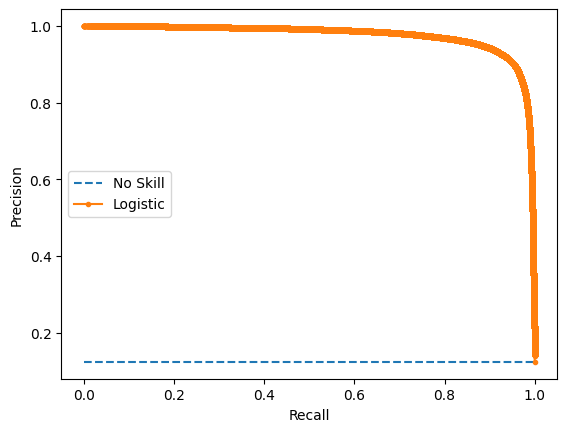

In [47]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

y_score = best_random.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

# predict class values
yhat = best_random.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_score)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [48]:
from sklearn.metrics import confusion_matrix

y_score = best_random.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_score)

In [49]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_score, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    print()
    print('Precision score: ', format(precision_score(y_test, y_pred_adj)))
    print('Recall score: ', format(recall_score(y_test, y_pred_adj)))

    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.0, 1.01]);
    plt.xlim([0.0, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg   1714973     19041
pos     17038    228948

Precision score:  0.9232183685566698
Recall score:  0.9307358955387705


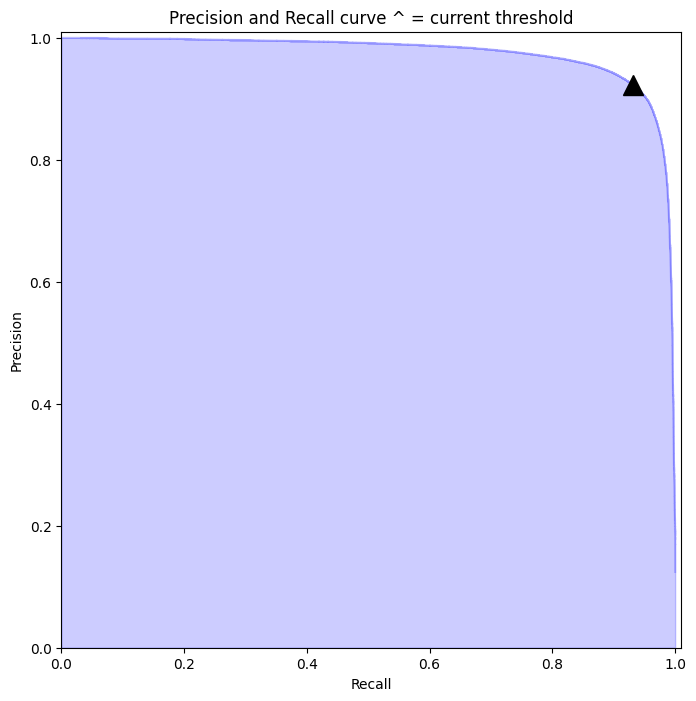

In [50]:
precision_recall_threshold(p, r, thresholds, 0.5)

##### Feature Importances:

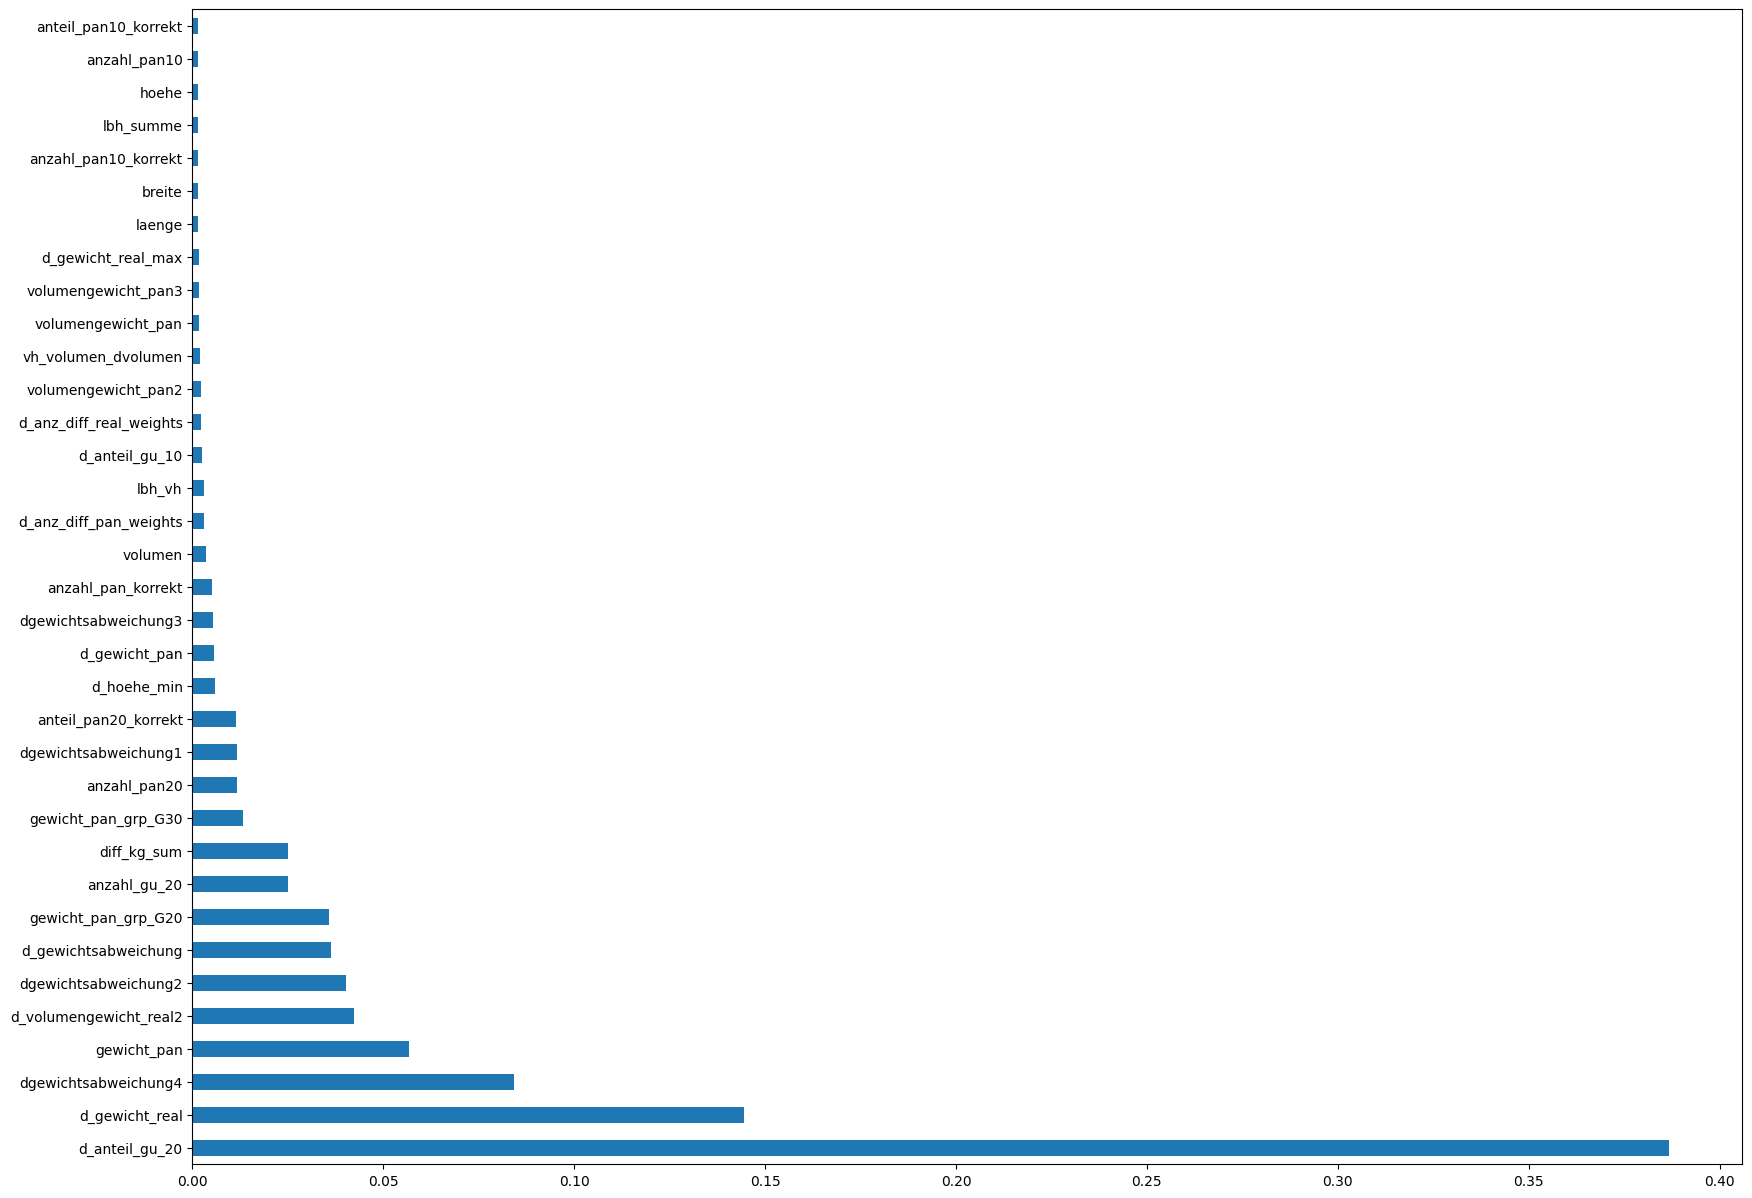

In [37]:
feat_importances = pd.Series(best_random.feature_importances_, index=X_train.columns.values)
feat_importances.nlargest(35).plot(kind='barh', figsize=(20, 15))

plt.show()

[0.38666499 0.14439734 0.08420746 0.05682105 0.04239496 0.04024833
 0.03633104 0.03569208 0.02495614 0.02494805 0.01313866 0.01178751
 0.01169629 0.01151727 0.00576988]
['d_anteil_gu_20' 'd_gewicht_real' 'dgewichtsabweichung4' 'gewicht_pan'
 'd_volumengewicht_real2' 'dgewichtsabweichung2' 'd_gewichtsabweichung'
 'gewicht_pan_grp_G20' 'anzahl_gu_20' 'diff_kg_sum' 'gewicht_pan_grp_G30'
 'anzahl_pan20' 'dgewichtsabweichung1' 'anteil_pan20_korrekt'
 'd_hoehe_min']


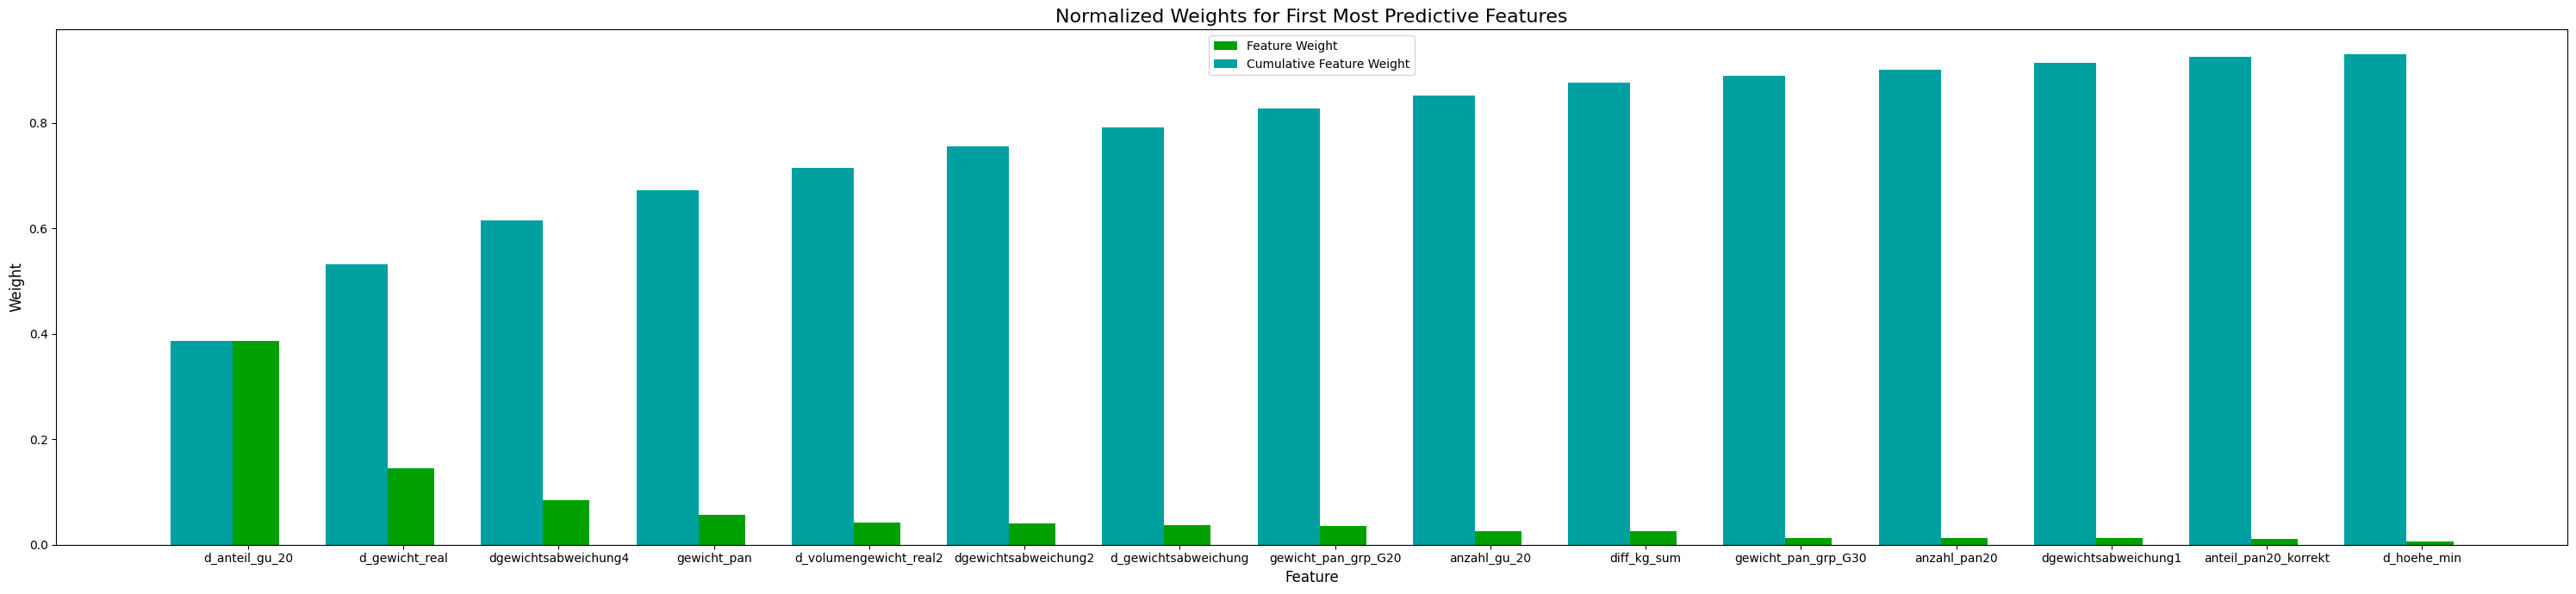

In [38]:
# TODO: Extract the feature importances using .feature_importances_ 
importances = best_random.feature_importances_

def feature_plot(importances, X_train, y_train, Anzahl_features):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:Anzahl_features]]
    values = importances[indices][:Anzahl_features]
    
    print(values)
    print(columns)

    # Creat the plot
    fig = plt.figure(figsize = (30,7))
    plt.title("Normalized Weights for First Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(Anzahl_features), values, width = 0.4, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(Anzahl_features) - 0.3, np.cumsum(values), width = 0.4, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(Anzahl_features), columns)
    #plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  


# Plot
feature_plot(importances, X_train, y_train,15)

### Validierung des Models

In [39]:
# Time taken to Make new predictions with base model
import time
start_time = time.time()
Erg2 = base_model.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))




--- 6.104733228683472 seconds ---


In [40]:
# Time taken to Make new predictions with tuned model
import time
start_time = time.time()
Erg2 = best_random.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))



--- 5.372830390930176 seconds ---


### Save the Model

In [41]:
Dateiname = 'GS_RF_Klassifikation_HER_GU_20_nat.pkl'
    
print(Dateiname)

Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname


import pickle

with open(Speicherort, 'wb') as f:
    pickle.dump(best_random, f)

GS_RF_Klassifikation_HER_GU_20_nat.pkl


### Load the model

In [42]:
Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname                                                                                                                                                                                                   
with open(Speicherort, 'rb') as f:
    RF_Doppleridentifizierung = pickle.load(f)

Erg3 = RF_Doppleridentifizierung.predict(X_test)
Erg3

array([0, 0, 0, ..., 0, 0, 0])

In [45]:
# # Bewertung
 
# # Erstellen eines Datenwörterbuchs mit der dritten Datengruppe
# data = {
#     'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
#     'First Test': [0.997, 0.747, 0.521, 0.614],
#     'Second Test': [0.997, 0.733, 0.474, 0.576],
#     'Test with weight_grp': [0.997, 0.732, 0.474,0.575] ,
#     'Test without outliers': [0.997, 0.752, 0.486,0.590]
    
# }

# # Erstellen eines DataFrames
# df = pd.DataFrame(data)
 
# # DataFrame anzeigen
# print(df)
 
# # Daten extrahieren
# metrics = df['Metric']
# first_test_values = df['First Test']
# second_test_values = df['Second Test']
# third_test_values = df['Test with weight_grp']
# fourth_test_values = df['Test without outliers']

# x = np.arange(len(metrics))  # Position der Labels
# width = 0.25  # Breite der Balkendiagramme
 
# # Erstellen von Figuren und Achsen
# fig, ax = plt.subplots()
 
# rects1 = ax.bar(x - 1.5 * width, first_test_values, width, label='Erster Test')
# rects2 = ax.bar(x - 0.5 * width, second_test_values, width, label='Zweiter Test')
# rects3 = ax.bar(x + 0.5 * width, third_test_values, width, label='weight_grp Test')
# rects4 = ax.bar(x + 1.5 * width, fourth_test_values, width, label='without outliers')

# # Add labels, title, and legend
# ax.set_xlabel('Metriken')
# ax.set_title('Vergleich der Modellleistungsmetriken')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics)
# ax.legend()
 
# # Automatisches Anpassen des Layouts
# fig.tight_layout()
 
# # Diagramm anzeigen
# plt.show()

# Model for classifying parcels with weight greater than 10kg

In [46]:
# # Import train_test_split
# from sklearn.model_selection import train_test_split

# # Split the 'features' and 'income' data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(GS_Trainset_features, 
#                                                     GS_Trainset_targetvar_GU_10, 
#                                                     test_size = 0.3, 
#                                                     random_state = 0)

# # Show the results of the split
# print("Training set has {} samples.".format(X_train.shape[0]))
# print("Testing set has {} samples.".format(X_test.shape[0]))

In [47]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.metrics import fbeta_score
# from sklearn.metrics import roc_curve, auc, roc_auc_score

# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     accuracy = accuracy_score(test_labels, predictions)
#     f1_score_erg = f1_score(test_labels, predictions)
#     print('Accuracy score: ', format(accuracy_score(test_labels, predictions)))
#     print('Precision score: ', format(precision_score(test_labels, predictions)))
#     print('Recall score: ', format(recall_score(test_labels, predictions)))
#     print('F1 score: ', format(f1_score(test_labels, predictions)))
#     #print('Beta score: ', format(fbeta_score(test_labels, predictions, beta=1))
#     print('\n\n')
#     return f1_score_erg

# import time
# start_time = time.time()

# base_model = RandomForestClassifier(random_state = 33, n_jobs = 44)
# base_model.fit(X_train,y_train)
# base_f1_score = evaluate(base_model, X_test,y_test)

# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()

# best_random = RandomForestClassifier(n_estimators=100, min_samples_split = 20, min_samples_leaf = 10, max_features = 40, max_depth = 25, criterion = 'entropy', bootstrap = False,  random_state = 33, n_jobs = 44)
# best_random.fit(X_train,y_train)
# random_f1_score = evaluate(best_random, X_test,y_test)

# print("--- %s seconds ---" % (time.time() - start_time))
# print('Improvement of {:0.2f}%.'.format( 100 * (random_f1_score - base_f1_score) / base_f1_score))

In [48]:
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import average_precision_score
# from matplotlib import pyplot

# y_score = best_random.predict_proba(X_test)[:, 1]
# average_precision = average_precision_score(y_test, y_score)

# print('Average precision-recall score: {0:0.2f}'.format(
#       average_precision))

# # predict class values
# yhat = best_random.predict(X_test)
# lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_score)
# lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

# # summarize scores
# print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# # plot the precision-recall curves
# no_skill = len(y_test[y_test==1]) / len(y_test)
# pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# # axis labels
# pyplot.xlabel('Recall')
# pyplot.ylabel('Precision')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()

In [49]:
# from sklearn.metrics import confusion_matrix

# y_score = best_random.predict_proba(X_test)[:, 1]
# p, r, thresholds = precision_recall_curve(y_test, y_score)

In [50]:
# def adjusted_classes(y_scores, t):
#     """
#     This function adjusts class predictions based on the prediction threshold (t).
#     Will only work for binary classification problems.
#     """
#     return [1 if y >= t else 0 for y in y_scores]

# def precision_recall_threshold(p, r, thresholds, t=0.5):
#     """
#     plots the precision recall curve and shows the current value for each
#     by identifying the classifier's threshold (t).
#     """
    
#     # generate new class predictions based on the adjusted_classes
#     # function above and view the resulting confusion matrix.
#     y_pred_adj = adjusted_classes(y_score, t)
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
#                        columns=['pred_neg', 'pred_pos'], 
#                        index=['neg', 'pos']))
    
#     print()
#     print('Precision score: ', format(precision_score(y_test, y_pred_adj)))
#     print('Recall score: ', format(recall_score(y_test, y_pred_adj)))

    
#     # plot the curve
#     plt.figure(figsize=(8,8))
#     plt.title("Precision and Recall curve ^ = current threshold")
#     plt.step(r, p, color='b', alpha=0.2,
#              where='post')
#     plt.fill_between(r, p, step='post', alpha=0.2,
#                      color='b')
#     plt.ylim([0.0, 1.01]);
#     plt.xlim([0.0, 1.01]);
#     plt.xlabel('Recall');
#     plt.ylabel('Precision');
    
#     # plot the current threshold on the line
#     close_default_clf = np.argmin(np.abs(thresholds - t))
#     plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
#             markersize=15)

In [51]:
# precision_recall_threshold(p, r, thresholds, 0.5)

In [52]:
# feat_importances = pd.Series(best_random.feature_importances_, index=X_train.columns.values)
# feat_importances.nlargest(35).plot(kind='barh', figsize=(20, 15))

# plt.show()

In [53]:
# # TODO: Extract the feature importances using .feature_importances_ 
# importances = best_random.feature_importances_

# def feature_plot(importances, X_train, y_train, Anzahl_features):
    
#     # Display the five most important features
#     indices = np.argsort(importances)[::-1]
#     columns = X_train.columns.values[indices[:Anzahl_features]]
#     values = importances[indices][:Anzahl_features]
    
#     print(values)
#     print(columns)

#     # Creat the plot
#     fig = plt.figure(figsize = (30,7))
#     plt.title("Normalized Weights for First Most Predictive Features", fontsize = 16)
#     plt.bar(np.arange(Anzahl_features), values, width = 0.4, align="center", color = '#00A000', \
#           label = "Feature Weight")
#     plt.bar(np.arange(Anzahl_features) - 0.3, np.cumsum(values), width = 0.4, align = "center", color = '#00A0A0', \
#           label = "Cumulative Feature Weight")
#     plt.xticks(np.arange(Anzahl_features), columns)
#     #plt.xlim((-0.5, 4.5))
#     plt.ylabel("Weight", fontsize = 12)
#     plt.xlabel("Feature", fontsize = 12)
    
#     plt.legend(loc = 'upper center')
#     plt.tight_layout()
#     plt.show()  


# # Plot
# feature_plot(importances, X_train, y_train,15)

# Save the model

In [54]:
# Dateiname = 'GS_RF_Klassifikation_HER_GU_10_nat.pkl'
    
# print(Dateiname)


# Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname


# import pickle

# with open(Speicherort, 'wb') as f:
#     pickle.dump(best_random, f)

# Load the Model

In [55]:
# Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname                                                                                                                                                                                                   
# with open(Speicherort, 'rb') as f:
#     RF_Doppleridentifizierung = pickle.load(f)

# Erg3 = RF_Doppleridentifizierung.predict(X_test)
# Erg3

#  Prognose des Gewichts einer Sendung (GS_Trainset_targetvar_GR)

In [23]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(GS_Trainset_features, 
                                                    GS_Trainset_targetvar_GR, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 3465000 samples.
Testing set has 1485000 samples.


In [ ]:

#Regression:

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    r2_score_erg = r2_score(test_labels, predictions)
    print('R2 score: ', format(r2_score_erg))
    print('mean squared error: ', format(mean_squared_error(test_labels, predictions)))
    print('mean absolute error: ', format(mean_absolute_error(test_labels, predictions)))
    print('\n\n')
    return r2_score_erg


import time
start_time = time.time()

base_model_reg = RandomForestRegressor(random_state = 33, n_jobs = 44)
base_model_reg.fit(X_train,y_train)
base_r2_score = evaluate(base_model_reg, X_test,y_test)

print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()

best_random_reg = RandomForestRegressor(n_estimators=50, min_samples_split = 5, min_samples_leaf = 5, max_features = 35, max_depth = 23, bootstrap = True,  random_state = 33, n_jobs = 44)
best_random_reg.fit(X_train,y_train)
random_r2_score = evaluate(best_random_reg, X_test,y_test)

print("--- %s seconds ---" % (time.time() - start_time))


print('Improvement of {:0.2f}%.'.format( 100 * (random_r2_score - base_r2_score) / base_r2_score))

In [ ]:
feat_importances = pd.Series(best_random_reg.feature_importances_, index=X_train.columns.values)
feat_importances.nlargest(35).plot(kind='barh', figsize=(20, 15))

plt.show()

In [ ]:
# TODO: Extract the feature importances using .feature_importances_ 
importances = best_random_reg.feature_importances_

def feature_plot(importances, X_train, y_train, Anzahl_features):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:Anzahl_features]]
    values = importances[indices][:Anzahl_features]
    
    print(values)
    print(columns)

    # Creat the plot
    fig = plt.figure(figsize = (30,7))
    plt.title("Normalized Weights for First Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(Anzahl_features), values, width = 0.4, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(Anzahl_features) - 0.3, np.cumsum(values), width = 0.4, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(Anzahl_features), columns)
    #plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  


# Plot
feature_plot(importances, X_train, y_train,15)

In [ ]:
# Make new predictions
import time
start_time = time.time()
Erg2 = best_random_reg.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))


# < 15 Sek

In [ ]:
# Make new predictions
import time
start_time = time.time()
Erg2 = base_model_reg.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))


# < 15 Sek

### Model speichern

In [ ]:

Dateiname = 'GS_RF_Prognose_Gewicht_Herkules_nat.pkl'

print(Dateiname)
Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname        


import pickle

with open(Speicherort, 'wb') as f:
    pickle.dump(best_random_reg, f)

### Model Laden

In [ ]:
Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname                                                                                                                                                                                                    

with open(Speicherort, 'rb') as f:
    RF_Weight_prediction = pickle.load(f)


Erg3 = RF_Weight_prediction.predict(X_test)
Erg3

# Data set for SVM model

In [59]:
GS_Trainset_sample_svm.head()

,gewicht_pan,gewicht_real,flag_gewicht_20,flag_gewicht_10,volumen,laenge,breite,hoehe,d_anzahl,d_anz_diff_pan_weights,d_anz_diff_real_weights,d_hoehe,d_hoehe_min,d_hoehe_max,d_laenge,d_laenge_min,d_laenge_max,d_breite,d_breite_min,d_breite_max,d_gewicht_real,d_gewicht_real_min,d_gewicht_real_max,d_gewicht_pan,d_gewicht_pan_min,d_gewicht_pan_max,d_volumen,d_volumen_min,d_volumen_max,d_volumengewicht_real,d_volumengewicht_pan,d_lbh_summe,d_volumengewicht_real2,d_volumengewicht_pan2,anzahl_gu_20,anzahl_gu_10,d_gewichtsabweichung,d_gewichtsabweichung_min,d_gewichtsabweichung_max,d_anteil_gu_20,d_anteil_gu_10,anzahl_pan20_korrekt,anzahl_pan20,anzahl_pan10_korrekt,anzahl_pan10,anzahl_pan_korrekt,anteil_pan20_korrekt,anteil_pan10_korrekt,diff_kg_sum,vh_laenge_hoehe,vh_laenge_breite,vh_hoehe_breite,vh_volumen_laenge,vh_volumen_breite,vh_volumen_hoehe,vh_laenge_dlaenge,vh_breite_dbreite,vh_hoehe_dhoehe,vh_volumen_dvolumen,vh_gewicht_dgewicht,vh_gewicht_dgewicht_pan,dgewichtsabweichung1,dgewichtsabweichung2,dgewichtsabweichung3,dgewichtsabweichung4,dgewichtsabweichung5,dgewichtsabweichung6,lbh_summe,lbh_vh,volumengewicht_pan,volumengewicht_pan2,volumengewicht_pan3,vh_volumengewicht_pan,vh_volumengewicht_pan2,volumen_grp_V30,volumen_grp_V40,volumen_grp_V50,volumen_grp_V70,volumen_grp_V90,volumen_grp_V99,parcel_shape_bag,parcel_shape_cuboid,parcel_shape_envelope,parcel_shape_unknown,gewicht_pan_grp_G05,gewicht_pan_grp_G10,gewicht_pan_grp_G15,gewicht_pan_grp_G20,gewicht_pan_grp_G30,gewicht_pan_grp_G99
2539539,1.665,1.70,0,0,53.0,544.0,361.0,270.0,27.0,753.0,183.0,247.0,115.0,480.0,599.0,394.0,1050.0,403.0,208.0,585.0,2.0,0.0,10.0,2.0,0.000,12.000,57.0,50.0,69.0,4.0,4.0,12.0,6.0,6.0,0.0,0.0,0.0,0.0,-2.0,0.00,0.00,0.0,0.0,0.0,0.0,5489.0,1.00,1.00,0.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,10.0,10.0,-2.0,8.0,8.0,12.0,100.0,3.0,7.0,7.0,2.0,4.0,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False
2217575,1.000,2.05,0,0,11.0,298.0,183.0,198.0,432.0,1.0,1009.0,119.0,10.0,490.0,297.0,105.0,1300.0,195.0,39.0,708.0,1.0,0.0,32.0,1.0,1.000,1.000,7.0,1.0,29.0,14.0,14.0,6.0,6.0,6.0,50.0,403.0,0.0,-1.0,15.0,0.00,0.00,0.0,50.0,0.0,453.0,1772631.0,0.00,0.00,0.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,10.0,10.0,10.0,-1.0,15.0,15.0,7.0,117.0,9.0,7.0,6.0,2.0,4.0,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
2161057,6.270,6.25,0,0,8.0,919.0,165.0,50.0,309.0,986.0,920.0,120.0,10.0,464.0,312.0,70.0,1635.0,203.0,16.0,1211.0,2.0,0.0,31.0,1.0,0.000,30.000,9.0,1.0,30.0,22.0,11.0,6.0,3.0,6.0,21.0,117.0,1.0,0.0,1.0,0.00,0.00,9.0,30.0,667.0,801.0,325505.0,30.00,83.00,0.0,18.0,6.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,3.0,6.0,14.0,9.0,15.0,-2.0,15.0,15.0,11.0,150.0,50.0,2.0,1.0,10.0,1.0,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False
2045240,1.000,1.00,0,0,22.0,907.0,206.0,116.0,11.0,4.0,105.0,164.0,20.0,315.0,739.0,195.0,971.0,215.0,67.0,901.0,1.0,0.0,21.0,1.0,1.000,2.000,24.0,1.0,30.0,4.0,4.0,11.0,11.0,11.0,1.0,2.0,0.0,-1.0,15.0,0.00,0.00,0.0,1.0,0.0,3.0,5311.0,0.00,0.00,0.0,8.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,10.0,10.0,-1.0,15.0,15.0,12.0,109.0,5.0,12.0,11.0,4.0,3.0,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
1099754,8.000,11.25,0,1,45.0,497.0,276.0,330.0,1.0,9.0,15.0,260.0,170.0,335.0,524.0,392.0,600.0,344.0,276.0,411.0,9.0,2.0,12.0,8.0,1.000,14.000,45.0,40.0,49.0,20.0,18.0,11.0,1.0,1.0,0.0,4.0,1.0,1.0,-2.0,0.00,24.00,0.0,0.0,8.0,12.0,9.0,1.00,67.00,0.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0,9.0,10.0,-7.0,3.0,4.0,11.0,100.0,18.0,1.0,1.0,3.0,3.0,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False


In [51]:
# Split the data into features and target label
drop_col = ['gewicht_real',  'flag_gewicht_20', 'flag_gewicht_10']

GS_Trainset_targetvar_GR = GS_Trainset_sample_svm['gewicht_real']
GS_Trainset_targetvar_GU_20 = GS_Trainset_sample_svm['flag_gewicht_20']
GS_Trainset_targetvar_GU_10= GS_Trainset_sample_svm['flag_gewicht_10']


GS_Trainset_features = GS_Trainset_sample_svm.drop(drop_col, axis=1)

In [52]:
# scaling the data
from sklearn.preprocessing import StandardScaler

columns_scaled =GS_Trainset_features.columns
scaler = StandardScaler()
GS_Trainset_features_scaled = pd.DataFrame(data = GS_Trainset_features)
GS_Trainset_features_scaled[columns_scaled]=scaler.fit_transform(GS_Trainset_features[columns_scaled])

# Show an example of a record with scaling applied
display(GS_Trainset_features_scaled.head(n = 5))

,gewicht_pan,volumen,laenge,breite,hoehe,d_anzahl,d_anz_diff_pan_weights,d_anz_diff_real_weights,d_hoehe,d_hoehe_min,d_hoehe_max,d_laenge,d_laenge_min,d_laenge_max,d_breite,d_breite_min,d_breite_max,d_gewicht_real,d_gewicht_real_min,d_gewicht_real_max,d_gewicht_pan,d_gewicht_pan_min,d_gewicht_pan_max,d_volumen,d_volumen_min,d_volumen_max,d_volumengewicht_real,d_volumengewicht_pan,d_lbh_summe,d_volumengewicht_real2,d_volumengewicht_pan2,anzahl_gu_20,anzahl_gu_10,d_gewichtsabweichung,d_gewichtsabweichung_min,d_gewichtsabweichung_max,d_anteil_gu_20,d_anteil_gu_10,anzahl_pan20_korrekt,anzahl_pan20,anzahl_pan10_korrekt,anzahl_pan10,anzahl_pan_korrekt,anteil_pan20_korrekt,anteil_pan10_korrekt,diff_kg_sum,vh_laenge_hoehe,vh_laenge_breite,vh_hoehe_breite,vh_volumen_laenge,vh_volumen_breite,vh_volumen_hoehe,vh_laenge_dlaenge,vh_breite_dbreite,vh_hoehe_dhoehe,vh_volumen_dvolumen,vh_gewicht_dgewicht,vh_gewicht_dgewicht_pan,dgewichtsabweichung1,dgewichtsabweichung2,dgewichtsabweichung3,dgewichtsabweichung4,dgewichtsabweichung5,dgewichtsabweichung6,lbh_summe,lbh_vh,volumengewicht_pan,volumengewicht_pan2,volumengewicht_pan3,vh_volumengewicht_pan,vh_volumengewicht_pan2,volumen_grp_V30,volumen_grp_V40,volumen_grp_V50,volumen_grp_V70,volumen_grp_V90,volumen_grp_V99,parcel_shape_bag,parcel_shape_cuboid,parcel_shape_envelope,parcel_shape_unknown,gewicht_pan_grp_G05,gewicht_pan_grp_G10,gewicht_pan_grp_G15,gewicht_pan_grp_G20,gewicht_pan_grp_G30,gewicht_pan_grp_G99
504573,-0.547145,-0.545318,0.100136,0.673250,-0.800696,0.249851,-0.182397,-0.443280,-0.782314,-0.730693,-0.451323,0.432901,-0.135727,-0.815958,0.793874,-0.476951,0.526660,-0.488807,-0.181201,0.701290,-0.489669,-0.278510,0.254941,-0.392027,-0.46964,-0.216349,-0.595507,-0.410070,0.281275,1.505646,1.466204,-0.107764,-0.360109,0.056066,0.252945,0.685257,-0.105526,-0.163253,-0.124803,-0.131226,-0.175328,-0.182765,-0.261182,-0.512164,-0.802305,-0.061863,0.396021,-0.385227,-1.057395,0.0,-0.029555,-0.071561,-0.104993,-0.044884,-0.079264,-0.063314,-1.014840,-1.247006,-0.388136,-0.053311,-0.414123,0.569324,0.499719,0.492693,-0.105884,-0.725454,-0.757180,1.745543,1.684004,-0.620341,0.422412,0.519834,-0.272457,-0.207547,-0.21672,-0.170479,-0.173542,1.749373,-1.567172,-0.143972,-0.152596,0.40925,-0.266027,-0.184434,-0.146812,-0.141169,-0.062008
635475,-0.381856,-0.614042,-0.870567,-1.269611,-0.563027,2.905815,-0.573809,-0.093099,-0.577352,-0.502830,-0.044037,-1.014907,-0.595014,0.160557,-1.332559,-0.819711,-0.228825,-0.488807,-0.181201,-0.041768,-0.489669,-0.278510,0.158952,-0.606855,-0.46964,-0.216349,0.459415,0.160228,-1.294996,-0.101188,-0.060517,-0.113915,-0.335760,0.056066,0.252945,-0.092952,-0.105526,-0.163253,-0.124803,-0.131990,-0.175257,-0.182240,1.002261,-0.512164,-0.635274,-0.061863,-0.105134,0.841500,0.897307,0.0,-0.029555,-0.071561,-0.104993,-0.044884,-0.079264,-0.063314,-0.077239,0.034111,-0.012135,-0.053311,0.026934,0.569324,0.499719,0.492693,-1.178664,-0.019586,1.138500,-0.618523,-0.618337,1.082759,-0.969779,0.519834,-0.272457,-0.207547,-0.21672,-0.170479,-0.173542,-0.571633,0.638092,-0.143972,-0.152596,0.40925,-0.266027,-0.184434,-0.146812,-0.141169,-0.062008
957220,-0.522272,-0.648403,-0.792911,-0.940493,-1.140222,-0.093697,-0.531872,-0.510465,-0.859175,-0.467774,-1.195404,-0.983603,-0.544909,-0.696196,-1.458383,-0.542866,-0.441638,-0.488807,-0.181201,-0.572523,-0.489669,0.298827,-0.992917,-0.642659,-0.46964,-0.216349,0.938926,0.419455,-1.294996,-0.101188,-0.060517,-0.115452,-0.331463,0.056066,-0.577763,0.814959,-0.105526,-0.163253,-0.124803,-0.132181,-0.175328,-0.182240,-0.295993,-0.483219,-0.802305,-0.061863,0.396021,-0.385227,-1.057395,0.0,-0.029555,-0.071561,-0.104993,-0.044884,-0.079264,-0.063314,-0.077239,0.034111,-0.388136,-0.053311,-0.414123,0.569324,0.499719,0.492693,-1.178664,-0.019586,0.111673,0.670968,0.637485,-0.620341,0.886476,0.519834,-0.272457,-0.207547,-0.21672,-0.170479,-0.173542,-0.571633,0.638092,-0.143972,-0.152596,0.40925,-0.266027,-0.184434,-0.146812,-0.14116

In [53]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(GS_Trainset_features_scaled, 
                                                    GS_Trainset_targetvar_GU_20, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 173250 samples.
Testing set has 74250 samples.


In [54]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

from sklearn.metrics import roc_curve, auc, roc_auc_score

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    f1_score_erg = f1_score(test_labels, predictions)
    print('Accuracy score: ', format(accuracy_score(test_labels, predictions)))
    print('Precision score: ', format(precision_score(test_labels, predictions)))
    print('Recall score: ', format(recall_score(test_labels, predictions)))
    print('F1 score: ', format(f1_score(test_labels, predictions)))
    #print('Beta score: ', format(fbeta_score(test_labels, predictions, beta=1))
    print('\n\n')
    return f1_score_erg

#Using SVM model for classifying the parcels greater than 20kg with deault parameters
import time
start_time = time.time()

# import SVC classifier
from sklearn.svm import SVC

# instantiate classifier 
svc=SVC(probability=True) 

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
svc_score =evaluate(svc,X_test,y_test)

print("--- %s seconds ---" % (time.time() - start_time))

Accuracy score:  0.996983164983165
Precision score:  0.5806451612903226
Recall score:  0.15384615384615385
F1 score:  0.24324324324324326



--- 709.188657283783 seconds ---


In [55]:
Dateiname = 'GS_SVM_Klassifikation_HER_GU_20_vmadasu.pkl'
    
print(Dateiname)

Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname


import pickle

with open(Speicherort, 'wb') as f:
    pickle.dump(svc, f)

GS_SVM_Klassifikation_HER_GU_20_vmadasu.pkl


In [56]:
Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname                                                                                                                                                                                                   
with open(Speicherort, 'rb') as f:
    RF_Doppleridentifizierung = pickle.load(f)

Erg3 = RF_Doppleridentifizierung.predict(X_test)
Erg3

array([0, 0, 0, ..., 0, 0, 0])

In [57]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(GS_Trainset_features_scaled, 
                                                    GS_Trainset_targetvar_GR, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 173250 samples.
Testing set has 74250 samples.


In [58]:

#Regression:

from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    r2_score_erg = r2_score(test_labels, predictions)
    print('R2 score: ', format(r2_score_erg))
    print('mean squared error: ', format(mean_squared_error(test_labels, predictions)))
    print('mean absolute error: ', format(mean_absolute_error(test_labels, predictions)))
    print('\n\n')
    return r2_score_erg


import time
start_time = time.time()

base_model = SVR()
base_model.fit(X_train,y_train)
base_score = evaluate(base_model, X_test,y_test)

print("--- %s seconds ---" % (time.time() - start_time))

R2 score:  0.9298852895132237
mean squared error:  1.560451763533311
mean absolute error:  0.4336288656265739



--- 8093.962639331818 seconds ---


In [59]:
Dateiname = 'GS_SVM_Regression_HER_GU_20_vmadasu.pkl'
    
print(Dateiname)

Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname


import pickle

with open(Speicherort, 'wb') as f:
    pickle.dump(base_model, f)

GS_SVM_Regression_HER_GU_20_vmadasu.pkl


In [60]:
Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname                                                                                                                                                                                                   
with open(Speicherort, 'rb') as f:
    RF_Doppleridentifizierung = pickle.load(f)

Erg3 = RF_Doppleridentifizierung.predict(X_test)
Erg3

array([1.18505744, 3.04705682, 1.78871827, ..., 1.00206573, 3.05679405,
       1.79641785])

In [61]:
#Total number of models
#Random Forest Classifier with 20kg
#Random Forest Classifier with 10kg
#Random Forest Regressor with 20kg
#SVM Classifier with 20kg
#SVM Regressor with 20kg

# ENDE!!!